# Basic usage of the Python luxpy package for color science 
* Author: K. A.G. Smet
* Version: 1.5.3
* Date: Sep 12, 2020
* License: GPLv3
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.1298963.svg)](https://doi.org/10.5281/zenodo.1298963)

If you use the package, please cite the following **tutorial paper** published in **LEUKOS**:
[**Smet, K. A. G. (2019). Tutorial: The LuxPy Python Toolbox for Lighting and Color Science. LEUKOS, 1–23. DOI: 10.1080/15502724.2018.1518717**](https://www.tandfonline.com/doi/full/10.1080/15502724.2018.1518717)

## Basic imports

In [1]:
import luxpy as lx # package for color science calculations 
print('Luxpy version: ',lx.__VERSION__) # print current luxpy version
import matplotlib.pyplot as plt # package for plotting
import numpy as np # fundamental package for scientific computing 
import timeit # package for timing functions
 
%matplotlib inline 

Luxpy version:  v1.5.3


#### This notebook will only illustrate the basic usage of some of the luxpy modules and functions.
**A full overview of all luxpy package modules and functions can be found in [LuxPy_Documentation.pdf](https://github.com/ksmet1977/luxpy/blob/master/LuxPy_Documentation.pdf).
Each module and function also has a detailed  \__docstring__ for help.**

In [2]:
?lx.spd_to_xyz # get help on function input and output arguments
?lx.cri # get help on cri sub-package

Object `lx.spd_to_xyz # get help on function input and output arguments` not found.
Object `lx.cri # get help on cri sub-package` not found.


## Working with spectral data

### _CIE_ILLUMINANTS, _CIE_F_SERIES, _CIE_F3_SERIES, _CIE_HP_SERIES, _CIE_LED_SERIES
Various light source and illuminant spectra can be found in various ndarrays and dictionaries. These 'built-in' objects, default values and dictioanries start with an underscore `_` and are written in `_ALL_CAPITAL` format, e.g. a dictionary `_CIE_ILLUMINANTS` contains a range of CIE illuminants accessible by name (key). **Spectra in luxpy are stored in row-format (first row are wavelengths)!!!**

In [2]:
print('Type of CIE illuminants in dictionary:',lx._CIE_ILLUMINANTS['types'])
print('\nD65 spectral data (1st row always wavelength): \n',lx._CIE_ILLUMINANTS['D65'])

Type of CIE illuminants in dictionary: ['E', 'D65', 'A', 'B', 'C', 'F4', 'F1', 'F2', 'F3', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F3.1', 'F3.2', 'F3.3', 'F3.4', 'F3.5', 'F3.6', 'F3.7', 'F3.8', 'F3.9', 'F3.10', 'F3.11', 'F3.12', 'F3.13', 'F3.14', 'F3.15', 'HP1', 'HP2', 'HP3', 'HP4', 'HP5', '_CIE_LED_SERIES', 'series']

D65 spectral data (1st row always wavelength): 
 [[3.6000e+02 3.6100e+02 3.6200e+02 3.6300e+02 3.6400e+02 3.6500e+02
  3.6600e+02 3.6700e+02 3.6800e+02 3.6900e+02 3.7000e+02 3.7100e+02
  3.7200e+02 3.7300e+02 3.7400e+02 3.7500e+02 3.7600e+02 3.7700e+02
  3.7800e+02 3.7900e+02 3.8000e+02 3.8100e+02 3.8200e+02 3.8300e+02
  3.8400e+02 3.8500e+02 3.8600e+02 3.8700e+02 3.8800e+02 3.8900e+02
  3.9000e+02 3.9100e+02 3.9200e+02 3.9300e+02 3.9400e+02 3.9500e+02
  3.9600e+02 3.9700e+02 3.9800e+02 3.9900e+02 4.0000e+02 4.0100e+02
  4.0200e+02 4.0300e+02 4.0400e+02 4.0500e+02 4.0600e+02 4.0700e+02
  4.0800e+02 4.0900e+02 4.1000e+02 4.1100e+02 4.1200e+02 4.1300e+02
  4.14

Shorthand acces is also available for a limited number of main CIE illuminants, such as `_CIE_A`, `_CIE_B`, `_CIE_C`, `_CIE_E`, `_CIE_D65`, `_CIE_F4`. 
Illuminant **series F (F1-F12)** are in `_CIE_F_SERIES`, **series F3.x (F3.1-F3.15)** in `_CIE_F3_SERIES`, **HP series (HP1- HP5)** in `_CIE_HP_SERIES`.
The **LED series (B1, B2, B3, B4, B5, BH1, RGB1, V1, V2)** can be found in `_CIE_LED_SERIES`

### Blackbody Radiators, Daylight Phase and CRI reference illuminants: cri_ref()

As a first example, let’s get (M = 4) spectra normalized at wavelength (`'lambda'`) 560 nm with respective CCTs of 3000 K, 4000 K, 4500 K and 6000 K and respective types: `'BB'` (blackbody radiator), `'DL'` (daylight phase), `'cierf'` (mixed reference illuminant as defined in (CIE224:2017, 2017)) and `'BB'`:

In [7]:
cieobs = '1964_10' # set CIE observer, i.e. cmf set
ccts = [3000,4000,4500, 6000] # define M = 4 CCTs
ref_types = ['BB','DL','cierf','DL'] # define reference illuminant types

# calculate reference illuminants:
REF = lx.cri_ref(ccts, ref_type = ref_types, norm_type = 'lambda', norm_f = 560)

print('* REF.shape --> (M + 1 x number of wavelengths): {}'.format(REF.shape)) 

* REF.shape --> (M + 1 x number of wavelengths): (5, 471)


### Plotting spectra
A simple plot of the spectral data in REF can be made by the following lines of code:

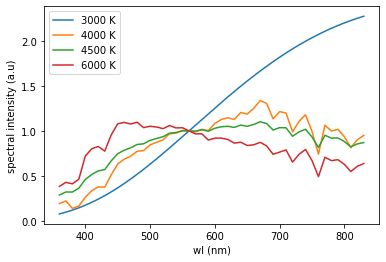

In [3]:
plt.plot(REF[0],REF[1:].T)
plt.xlabel('wl (nm)')
plt.ylabel('spectral intensity (a.u)')
plt.legend(['{} K'.format(x) for x in ccts])
plt.show()

A single spectrum can also be plotted either filled in with the spectral colors (set parameter `wavelength_height = 'spd'`) or with the latter shown as a bar at the bottom (set `wavelength_height = -0.05`; the percentage of the maximum spectrum value). 

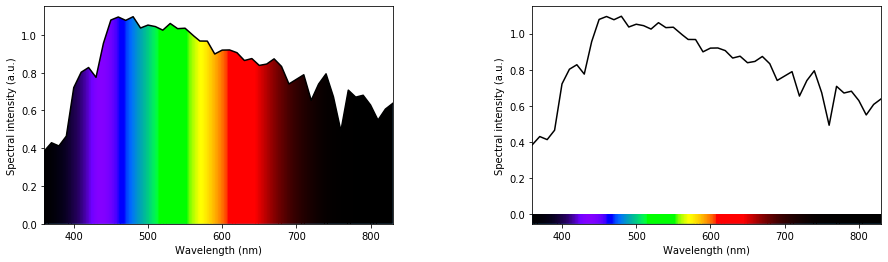

In [4]:
# Create figure with two subplots and adjust spacing between them:
fig = plt.figure(figsize=[15,4])
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
plt.subplots_adjust(wspace = 0.4) 

# Plot spectrum using bar and filled formats:
lx.plot_spectrum_colors(spd = REF[[0,-1],:], wavelength_height = 'spd', axh = ax1)
lx.plot_spectrum_colors(spd = REF[[0,-1],:], wavelength_height = -0.05, axh = ax2)

### Indoor illuminants: spd_to_indoor()
To get indoor versions of outdoor illuminants such as e.g D65, one can multiply them by the CIE spectral tranmission for glass (`_CIE_GLASS_ID['T']`). This can be easily done as follows:

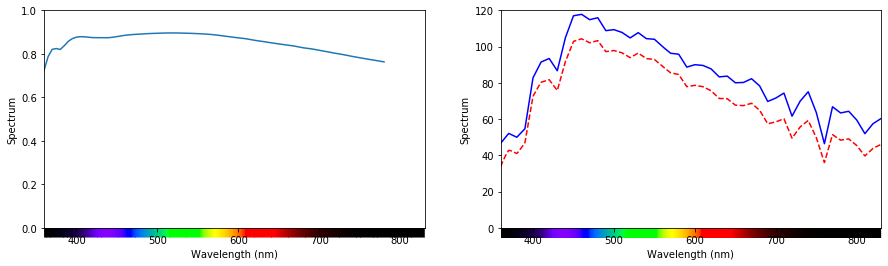

In [6]:
D65 = lx._CIE_D65
ID65 = lx.spd_to_indoor(D65) # create indoor version

fig, ax = plt.subplots(nrows=1, ncols = 2, figsize=[15,4])

plt.sca(ax[0]); # set current axes to ax[0]
lx.SPD(lx._CIE_GLASS_ID['T']).plot()
ax[0].set_ylim([0,1]); # set y-axis limits
plt.sca(ax[1]);lx.SPD(D65).plot(color = 'b', linestyle = '-')
plt.sca(ax[1]);lx.SPD(ID65).plot(color = 'r', linestyle = '--')
ax[1].set_ylim([0,120]);

### Spectral interpolation and extrapolation: cie_interp()

Spectra can be interpolated using `cie_interp`. CIE recommends different interpolation depending on the type of spectrum (e.g. light source spectrum, object spectral reflectance or transmission, color matching function, ...)
The type can be specified in the argument `kind`and the function will automatically select the right interpolation method. This can also be set directly, e.g. as `'linear'`. In the example below,`lx.getwlr()`sets a wavelength range in [start, stop, step] format. In the example, the spectra are interpolated and extrapolated between 400 nm and 900 nm. Following CIE recommendation, extrapolation is done by repeating the closest known value (hence the flat lines extending beyond 830 nm).
Let’s interpolate the REF spectral data to a 400 nm – 700 nm range with a 10 nm spacing, and let the `cie_interp()` function determine the right kind of interpolation by defining the spectral data type as `kind = 'S'`:

* REFi.shape --> (M + 1 x number of wavelengths): (5, 31)


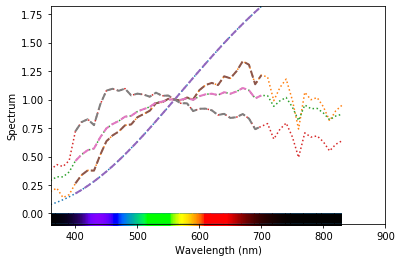

In [22]:
REFi = lx.cie_interp(REF, wl_new = np.arange(400,700+1,10), kind = 'S') 
print('* REFi.shape --> (M + 1 x number of wavelengths): {}'.format(REFi.shape))

# Make plots:
lx.SPD(REF).plot(linestyle=':')
lx.SPD(REFi).plot(linestyle='--', linewidth  = 2)
plt.xlim([360,900]);

One can override this default by setting `extrap_values='ext'`, in which case the normal extrapolation of numpy.interp1 is used. If one sets a tuple with two values, `extrap_values=(value at low end, value at high end)`, these values will be used to fill in the missing ends.

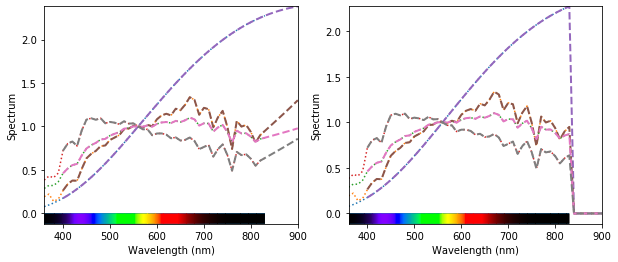

In [23]:
REF_400_900_10nm_extrap_ext = lx.cie_interp(REF.copy(), lx.getwlr([400,900,10]), kind = 'spd',extrap_values='ext')
REF_400_900_10nm_extrap_tuple = lx.cie_interp(REF.copy(), lx.getwlr([400,900,10]), kind = 'spd',extrap_values=(0,0))

# Make plots:
fig, ax = plt.subplots(nrows=1, ncols = 2, figsize=[10,4])
plt.sca(ax[0]); 
lx.SPD(REF).plot(linestyle=':')
lx.SPD(REF_400_900_10nm_extrap_ext).plot(linestyle='--', linewidth  = 2)
plt.xlim([360,900]);
plt.sca(ax[1]); 
lx.SPD(REF).plot(linestyle=':')
lx.SPD(REF_400_900_10nm_extrap_tuple).plot(linestyle='--', linewidth  = 2)
plt.xlim([360,900]);

### Spectral normalization: spd_normalize()
Spectra can be normalized using the `normalize_spd`function.
 * Normalization options are: 
     1. `'max'`: normalize spectral maximum to `norm_f`*max; 
     2. `'lambda'`: set a specific wavelength specified in `norm_f` to 1; 
     3. `'ru'`: normalize spectrum to a value of `norm_f` in radiometric units
     4. `'pu'`: normalize spectrum to a value of `norm_f` in photometric units
     5. `'area'`: normalize area to a value of `norm_f`

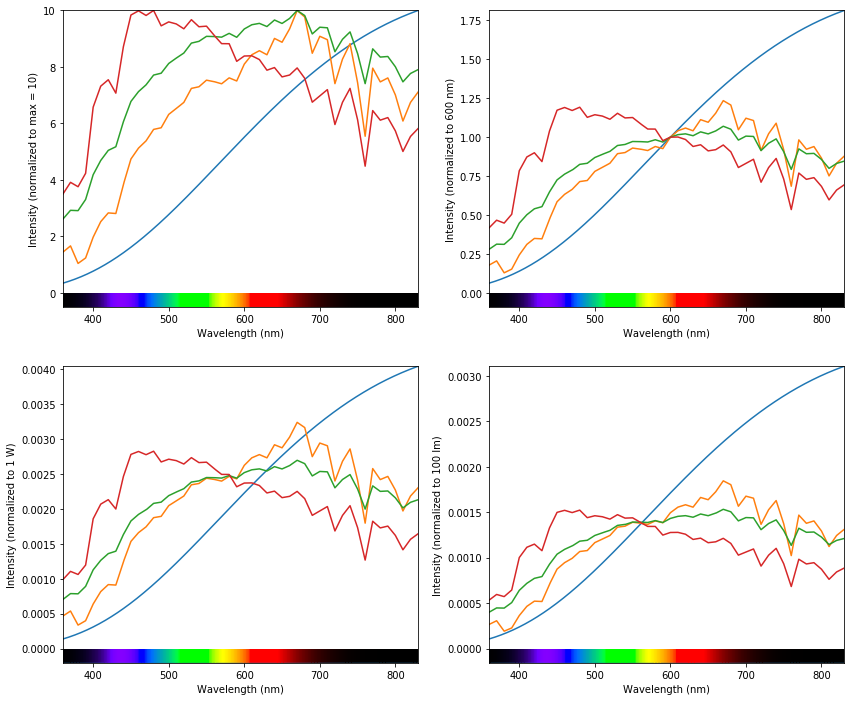

In [24]:
REF_normalized_to_max_10 = lx.spd_normalize(REF.copy(), norm_type = 'max', norm_f= 10) # max = 10, make copy because normalization is done in-place!
REF_normalized_to_wav_600nm = lx.spd_normalize(REF.copy(), norm_type = 'lambda',norm_f = 600) # wavelength 600 nm at 1
REF_normalized_ru_1W = lx.spd_normalize(REF.copy(), norm_type = 'ru',norm_f = 1) # 1 Watt
REF_normalized_pu_100lm = lx.spd_normalize(REF.copy(), norm_type = 'pu',norm_f = 100) # 100 lumen

# plot:
fig, ax = plt.subplots(nrows=2, ncols = 2, figsize=[14,12])
plt.sca(ax[0,0]);lx.SPD(REF_normalized_to_max_10).plot(ylabel='Intensity (normalized to max = 10)')
plt.sca(ax[0,1]);lx.SPD(REF_normalized_to_wav_600nm).plot(ylabel='Intensity (normalized to 600 nm)')
plt.sca(ax[1,0]);lx.SPD(REF_normalized_ru_1W).plot(ylabel='Intensity (normalized to 1 W)')
plt.sca(ax[1,1]);lx.SPD(REF_normalized_pu_100lm).plot(ylabel='Intensity (normalized to 100 lm)')

### Detect peak positions and fwhm in peaks of a spectrum: detect_peakwl()
First visually inspect how many peaks are in the spectrum. Then run the following command to get a list of dictionaries (one for each spectrum in input) with info on the detected peaks, set `verbosity = 1` to make a plot.

Peak properties: {'peaks_idx': array([ 75, 210], dtype=int64), 'peaks': array([4.5500e+02, 5.9000e+02]), 'heights': array([7.0354e-01, 1.0000e+00]), 'fwhms': array([2.1256e+01, 1.2084e+02]), 'fwhms_mid': array([4.5381e+02, 5.9631e+02]), 'fwhms_mid_heights': array([6.9610e-01, 9.9614e-01])}


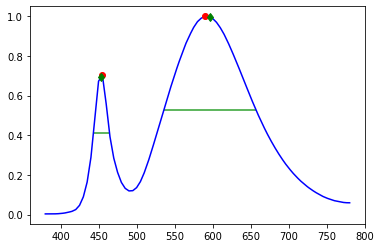

In [10]:
spd = lx._IESTM3018['S']['data'][[0,293],:] # get a phosphor white LED from ANSI/IES-TM30-2018 database
props = lx.detect_peakwl(spd, n = 2,verbosity = 1)

### REFLECTANCE SETS: _RFL

Some basic reflectance sets can be found in the `_RFL` dictionary. 

In [15]:
print(lx._RFL.keys())

dict_keys(['cri', 'munsell', 'macbeth', 'capbone', 'opstelten'])


Under key `'cri'` reflectance sets used in various color rendition calculators are stored. An image with color patches for each of the spectral reflectance functions illuminated by a specified illuminant spectrum can be generated using `plot_rfl_color_patches`.

dict_keys(['cie-13.3-1995', 'cie-224-2017', 'cri2012', 'ies-tm30-15', 'ies-tm30-18', 'ies-tm30', 'mcri', 'cqs'])


Text(0.5, 1.0, 'cie-224-2017 \n99 samples under Illuminant A')

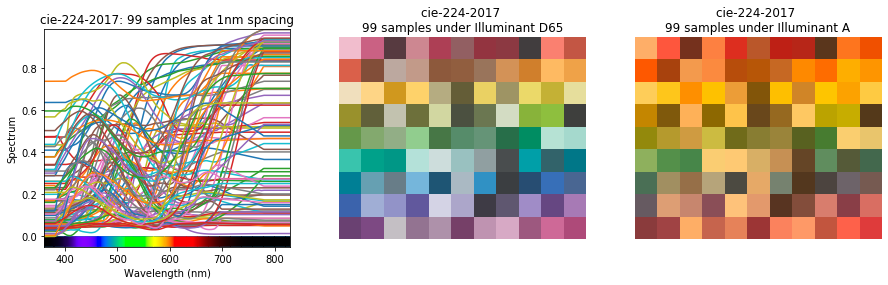

In [25]:
print(lx._RFL['cri'].keys())

rfl = lx._RFL['cri']['cie-224-2017']['99']['1nm']

fig = plt.figure(figsize=[15,4])
ax0 = fig.add_subplot(131)
plt.sca(ax0);
lx.SPD(rfl).plot();
ax0.set_title('cie-224-2017: 99 samples at 1nm spacing')

ax1 = fig.add_subplot(132)
lx.plot_rfl_color_patches(rfl, spd = lx._CIE_D65, ax = ax1)
ax1.set_title('cie-224-2017 \n99 samples under Illuminant D65')

ax2 = fig.add_subplot(133)
lx.plot_rfl_color_patches(rfl, spd = lx._CIE_A, ax = ax2)
ax2.set_title('cie-224-2017 \n99 samples under Illuminant A')

Under `'munsell'` the 1269 Munsell samples can be found, along with their Munsell designation, Chroma, Hue and Value. This can also be accessed using `_MUNSELL`. 

_MUNSELL keys: dict_keys(['cieobs', 'Lw', 'Yb', 'R', 'H', 'V', 'C', 'h', 'ab'])


Text(0.5, 1.0, '1269 Munsell samples under Illuminant C')

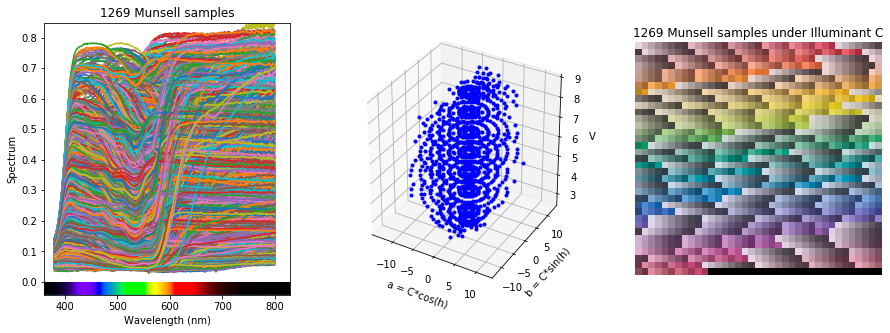

In [26]:
print('_MUNSELL keys:', lx._MUNSELL.keys())
fig = plt.figure(figsize=[15,5])
ax0 = fig.add_subplot(131)
plt.sca(ax0);lx.SPD(lx._MUNSELL['R']).plot();plt.title('1269 Munsell samples')

ax1 = fig.add_subplot(132, projection ='3d')
ax1.plot(lx._MUNSELL['ab'][:,0],lx._MUNSELL['ab'][:,1],lx._MUNSELL['V'][:,0],color='b',marker='.',linestyle='none')
ax1.set_xlabel('a = C*cos(h)')
ax1.set_ylabel('b = C*sin(h)')
ax1.set_zlabel('V');

ax1 = fig.add_subplot(133)
lx.plot_rfl_color_patches(lx._MUNSELL['R'], spd = lx._CIE_C, ax = ax1)
ax1.set_title('1269 Munsell samples under Illuminant C')

Under the `'macbeth'` key the 24 reflectance samples of the Macbeth ColorChecker Card can be found. Under `'capbone'` a large set of 114121 samples can be found. 

Text(0.5, 1.0, 'Macbeth ColorChecker')

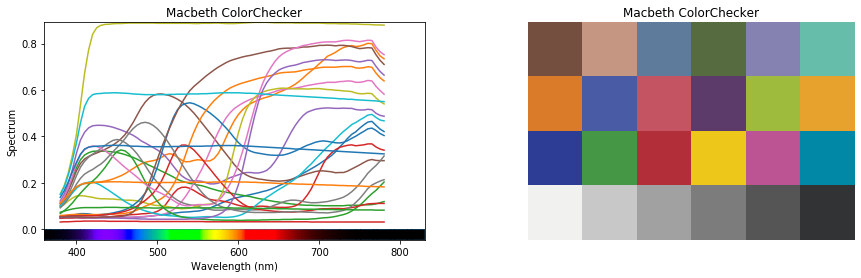

In [27]:
rfl = lx._RFL['macbeth']['CC']['R']

fig = plt.figure(figsize=[15,4])
ax0 = fig.add_subplot(121)
plt.sca(ax0);
lx.SPD(rfl).plot();
ax0.set_title('Macbeth ColorChecker')

ax1 = fig.add_subplot(122)
lx.plot_rfl_color_patches(rfl, ax = ax1)
ax1.set_title('Macbeth ColorChecker')

### Conversion from spectral to radiometric and photometric quantities: spd_to_power()

**Spectral quantities** (e.g. *spectral radiant power* **[W/nm]**, *spectral radiance* **[W/m².sr.nm],...)** can be converted to **radiometric quantities** (e.g. *radiant power* [W], *radiance* [W/m².r]) and **photometric quantities** (e.g. *luminous power* [lm], *luminance* [cd/m²]) using the `lx.spd_to_power()` function. The following code calculates the radiance and luminance for CIE illuminants D65 and A; both the CIE 1931 and CIE 1964 luminance values are calculated:

In [28]:
# Get some spectra (assume spectral radiance [W/nm.m³.sr])
D65 = lx._CIE_D65
A = lx._CIE_A

# combine to illustrate that function works for multiple spectra:
spd = np.vstack(([D65,A[1:]]))

# convert to radiometric units:
Le = lx.spd_to_power(spd, ptype = 'ru')
print('Radiance: \n', Le)

# convert to photometric units using the CIE 1931 2° observer (default):
L2 = lx.spd_to_power(spd, ptype = 'pu')
print('\nCIE 1931 2° luminance: \n', L2)

# convert to photometric units using the CIE 1964 10° observer:
L10 = lx.spd_to_power(spd, ptype = 'pu', cieobs = '1964_10')
print('\nCIE 1964 10° luminance: \n', L10)

Radiance: 
 [[3.9188e+04]
 [6.0076e+04]]

CIE 1931 2° luminance: 
 [[7.2173e+06]
 [7.3693e+06]]

CIE 1964 10° luminance: 
 [[7.9437e+06]
 [7.7789e+06]]


### Luminous Efficacy of Radiation (LER): spd_to_ler()
The luminous efficacy of radiation (LER) can be calculated using the `spd_to_ler()` function:

In [29]:
# Calculate LER for the CIE 1931 2° observer:
LER2 = lx.spd_to_ler(spd)
print('CIE 1931 2° LER [lm/W]: \n', LER2)

# Calculate LER for the CIE 1964 10° observer:
LER10 = lx.spd_to_ler(spd, cieobs = '1964_10')
print('\nCIE 1964 10° LER [lm/W]: \n', LER10)

CIE 1931 2° LER [lm/W]: 
 [[1.8417e+02]
 [1.2267e+02]]

CIE 1964 10° LER [lm/W]: 
 [[2.0271e+02]
 [1.2948e+02]]



### Tristimulus calculation: spd_to_xyz()

Next, the tristimulus values (using the CIE 1964 10° CMFs) of those light source spectra can be obtained as follows:

In [10]:
xyz_REF = lx.spd_to_xyz(REF, cieobs = cieobs) # illuminant xyz

The tristimulus values of set of N reflective samples illuminated by those M sources can be obtained in the following way:

In [8]:
TCS8 = lx._CRI_RFL['cie-13.3-1995']['8'] # 8 TCS from CIE 13.3-1995
xyz_TCS8_REF = lx.spd_to_xyz(REF, cieobs = cieobs, rfl = TCS8, relative = True) 

whereby relative = True (default) specifies that the output tristimulus values are normalized such that a perfect white diffuse sample has Y = 100.



The tristimulus values of the N samples illuminated by the M light sources and of the M light sources themselves can be obtained using (whereby the code is split over two lines using a line separator character ‘\’):

In [32]:
xyz_TCS8_REF_2, xyz_REF_2 = lx.spd_to_xyz(REF, cieobs = cieobs, \
                                          rfl = TCS8, relative = True, out = 2)

print('* xyz_TCS8_REF_2.shape --> (N x M x 3): {}'.format(xyz_TCS8_REF_2.shape))
print('* xyz_REF_2.shape --> (M x 3): {}'.format(xyz_REF_2.shape))

* xyz_TCS8_REF_2.shape --> (N x M x 3): (8, 4, 3)
* xyz_REF_2.shape --> (M x 3): (4, 3)


### CIE Standard Observers, Individual Observer Color Matching Functions and CIEOP06

Color matching functions are stored in a dictionary that can be accessed as follows:

In [33]:
# Get CIE 1931 2° CMFs:
cmf_1931 = lx._CMF['1931_2']['bar']

# List all available CMF sets:
print(lx._CMF['types'])

['1931_2', '1964_10', '2006_2', '2006_10', '2015_2', '2015_10', '1931_2_judd1951', '1931_2_juddvos1978', '1951_20_scotopic', 'cie_std_dev_obs_f1']


*Note that the 2006_x CMFs are the same as the 2015_x CMFs!*

A module called `indvcmf` supports Monte-Carlo generation of individual observer cone fundamentals and XYZ color matching functions (Asano, 2016).
The module has been extended enable the calculation of the XYZ color matching functions from LMS cone fundamentals as described in CIE TC1-97. It also offers the option to select different sources for the optical density and absorbance data (either `'asano'` or `'cietc197'`, which is the default since Dec 19, 2019). When only setting `fieldsize` and `age` CIEOP06 calculations are performed (see also https://github.com/ifarup/ciefunctions/tree/master/tc1_97, accessed Dec 18, 2019).


In [34]:
# To set the Asano settings:
lx.indvcmf.init(wl = None, dsrc_lms_odens = 'asano', lms_to_xyz_method = 'asano',
                use_sign_figs = True, use_my_round = True, use_chop = True, verbosity = 0)

# To set the default (CIEOP06: 'cietc197') settings:
lx.indvcmf.init()


Current state of 'global variables/settings': 

	_USE_MY_ROUND =  True
	_USE_SIGN_FIGS =  True
	_USE_CHOP =  True

	_WL = [390.00, 390.10, 390.20, ..., 829.80, 829.90, 830.00]
	_DSRC_STD_DEF =  matlab
	_DSRC_LMS_ODENS_DEF =  cietc197
	_LMS_TO_XYZ_METHOD =  cietc197

	Database dsrc_std =  matlab
	Database dsrc_lms_odens =  cietc197




Calculate CIEOP06 for observer age 40 and field size 5°:

In [35]:
#lx.indvcmf.init(verbosity = 0) # use default cietc197 settings without outputting current 'state'
xyzb_cieop06 = lx.indvcmf.compute_cmfs(fieldsize = 5, age = 40, out = 'XYZ')

CMFs can be plotted using a dedicated function `plot_cmfs()`:

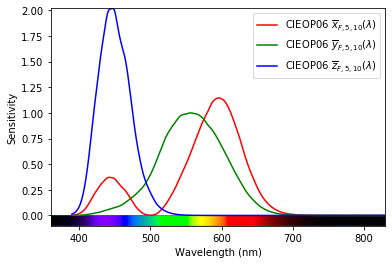

In [36]:
lx.plot_cmfs(xyzb_cieop06, cmf_symbols = ["x_{F,5,10}","y_{F,5,10}","z_{F,5,10}"], cmf_label = 'CIEOP06 ')

For example, a set cone fundamentals (lms) for a stimulus with field size of 6° for 20 observers aged 32 (using the default settings initiated in the previous cell) can be generated as follows:

(4, 20, 3)


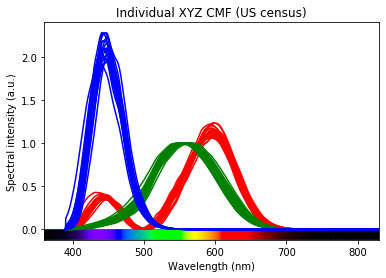

In [37]:
# Get set of 20 individual observer lms-CMFs 
lmsb = lx.indvcmf.genMonteCarloObs(n_obs = 20, list_Age = [32], fieldsize = 6)

# Use US 2010 population census to generate Age Distribution and output as XYZ CMF:
xyzb_us = lx.indvcmf.genMonteCarloObs(n_obs = 20, list_Age = 'us_census', fieldsize = 6, out ='XYZ')

# Plot CMFs:
plt.figure()

plt.plot(xyzb_us[0],xyzb_us[1], color ='r', linestyle='-')
plt.plot(xyzb_us[0],xyzb_us[2], color ='g', linestyle='-')
plt.plot(xyzb_us[0],xyzb_us[3], color ='b', linestyle='-')
plt.xlabel('Wavelength (nm)')
plt.ylabel('XYZbar (area normalized)')
plt.title('Individual XYZ CMF (US census)')

# Add bar with wavelength colors:
lx.plot_spectrum_colors(wavelength_height = -0.05,spdmax = 2.4, axh = plt.gca())

# CalculateXYZ values for REF:
xyz_ind = np.empty((REF.shape[0]-1, xyzb_us.shape[-1],3))
for i in range(xyzb_us.shape[-1]):
    xyz_ind[:,i,:] = lx.spd_to_xyz(REF, cieobs = xyzb_us[...,i],relative = True)
print(xyz_ind.shape)

Categorical observer CMFs can be generated in a similar manner using the indvcmf.genCatObs function.

### Mesopic luminous efficiency functions [CIE191:2010]

The CIE system for mesopic photometry [**CIE191:2010**] has also been implemented. The following code plots the mesopic $V_{mes,m}(\lambda)$ luminous efficiency functions for a range of adaptation coefficients $m$ and print the associated $K_{mes,m}$ coefficients:

m = 0.0, Kmesm = 1699.0 lm/W
m = 0.1, Kmesm = 1479.0 lm/W
m = 0.2, Kmesm = 1309.4 lm/W
m = 0.3, Kmesm = 1174.8 lm/W
m = 0.4, Kmesm = 1065.2 lm/W
m = 0.5, Kmesm = 974.3 lm/W
m = 0.6, Kmesm = 897.7 lm/W
m = 0.7, Kmesm = 832.3 lm/W
m = 0.8, Kmesm = 775.8 lm/W
m = 0.9, Kmesm = 726.4 lm/W
m = 1.0, Kmesm = 683.0 lm/W


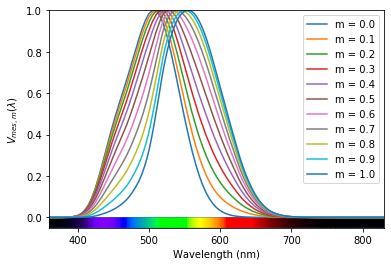

In [38]:
ms = np.arange(0,1.1,0.1)
for m in ms:
    Vmesm, Kmesm = lx.vlbar_cie_mesopic(m, out = 2)
    print('m = {:1.1f}, Kmesm = {:1.1f} lm/W'.format(m,Kmesm[0,0]))
    lx.SPD(Vmesm).plot(label = 'm = {:0.1f}'.format(m), ylabel='$V_{mes,m}(\lambda)$')
plt.legend()

The mesopic luminance $L_{mes,m}$ and adaptation coefficients $m$ for a given photopic luminance $L_p$ and scoptic luminance $L_s$ (or S/P ratio) can be calculated using:

In [39]:
Lmes1, m1 = lx.get_cie_mesopic_adaptation(Lp = 200, Ls = 100) 
Lmes2, m2 = lx.get_cie_mesopic_adaptation(Lp = 200, SP = 0.5) 
print('Lmes, m (Lp = 200, Ls = 100):', Lmes1, m1)
print('Lmes, m (Lp = 200, SP = 0.5):', Lmes2, m2)

Lmes, m (Lp = 200, Ls = 100): [2.3349e+02] [1.5566e+00]
Lmes, m (Lp = 200, SP = 0.5): [2.3349e+02] [1.5566e+00]


The mesopic $V_{mes,m}(\lambda)$ luminous efficiency function can also be directly obtained from $(L_p,L_s)$ or $(L_p,SP)$:

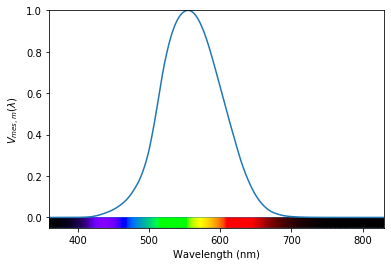

In [40]:
Vmes = lx.vlbar_cie_mesopic(Lp = 200, Ls = 100)
lx.SPD(Vmes).plot(ylabel='$V_{mes,m}(\lambda)$')

## Working with colorimetric data

The tristimulus values XYZ obtained earlier can be further transformed to a range of color coordinates. 

### xyz_to_Yuv()

As an example, the transformation to the CIE 1976 u’v’ chromaticity coordinates is outlined below:

In [41]:
Yuv_REF_2 = lx.xyz_to_Yuv(xyz_REF_2)
Yuv_TCS8_REF_2 = lx.xyz_to_Yuv(xyz_TCS8_REF_2)
print("* Yuv_REF_2.shape --> (M x 3): {}".format(Yuv_REF_2.shape))
print("* Yuv_TCS8_REF_2.shape --> (N x M x 3): {}".format(Yuv_TCS8_REF_2.shape))

* Yuv_REF_2.shape --> (M x 3): (4, 3)
* Yuv_TCS8_REF_2.shape --> (N x M x 3): (8, 4, 3)


### asplit(), plotSL() and plot_color_data()

The colorimetric data can be easily plotted. 
1. First the spectrum locus is drawn using `plotSL()`. This function has several input options (`cspace` and `cieobs` respectively determine the color space and CMF set to be used, `show = False` waits with showing the output graph until everything has been drawn in the axh axes, while `BBL = True` and `DL = True` regulate the plotting of a blackbody and daylight locus). 
2. In a next step, the data is prepared for easy plotting by splitting the data array along the colorimetric dimension (last axis).
3. Finally, the *u’,v’* chromaticity coordinates can be plotted.

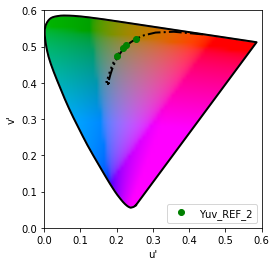

In [51]:
# Step 1:
axh = lx.plotSL(cspace = 'Yuv', cieobs = cieobs, show = False,\
                 BBL = True, DL = True, diagram_colors = True)

# Step 2:
Y, u, v = lx.utils.asplit(Yuv_REF_2) # splits array along last axis

# Step 3:
lx.plot_color_data(u, v, formatstr = 'go', axh = axh, label = 'Yuv_REF_2')

### colortf() 

A short-hand color transformation function also exists. This function makes it easy to combine several transformations in one function call. 
In the following example, tristimulus values XYZ are transformed to CIE 1976 *u’v’* chromaticity coordinates (`tf = 'Yuv'` defines the type of transform):


In [44]:
Yuv_REF = lx.colortf(xyz_REF_2, tf = 'Yuv') 

Note that the input does not have to be an array with tristimulus values. One can also perform transformation between for example an array with spectral data and CIE 1976 u’v’ chromaticity coordinates. Any combination of transformations for which the necessary forward (`xyz_to_...`) and backward (`…to_xyz`) functions are defined can be made. For example, the spectral data in REF can be readily converted to colorimetric data by specifying the correct transform type (`tf = 'spd>Yuv'`):

In [45]:
Yuv_REF = lx.colortf(REF, tf = 'spd>Yuv') 

Some color transformations require additional input parameters. This can be supplied as Python dictionary with the parameters names as keys. The forward and backward transform parameters should be supplied to the `colortf()` function using keyword arguments, `fwtf` and `bwtf`, respectively. 

For example, let’s transform the Yuv_REF to CIE 1976 CIELAB L\*a\*b\* coordinates, with as white point tristimulus values those of CIE illuminant A. First, the dictionary with input parameters for the forward (i.e. `xyz_to_lab`) transform is defined:

In [46]:
fwtf_userdefined = {'xyzw' : lx.spd_to_xyz(lx._CIE_ILLUMINANTS['A'])}

whereby the spectrum of the CIE illuminant A is obtained from a LuxPy database with CIE illuminants, i.e. `_CIE_ILLUMINANTS`.

Next, the transform can be made as follows:

In [47]:
lab_REF = lx.colortf(Yuv_REF, tf = 'Yuv>lab', fwtf = fwtf_userdefined)

Input parameters for the forward (only) transform can also be directly entered as keyword arguments to the `colortf()` function:

In [48]:
lab_REF2 = lx.colortf(Yuv_REF, tf = 'Yuv>lab',\
                      xyzw = lx.spd_to_xyz(lx._CIE_ILLUMINANTS['A']))


### xyz_to_cct() and cct_to_xyz()

The correlated color temperature (CCT) and distance to the blackbody locus (Duv) can be obtained, using the Ohno’s method (Ohno, 2014) or using a brute-force search method in the CIE 1960 UCS color space, as follows:

In [49]:
# Use Ohno's 2014 approach with a Look-Up-Table:
cct_ohno, duv_ohno = lx.xyz_to_cct(xyz_REF_2, cieobs = cieobs,\
                                   out = 'cct,duv', mode = 'lut') 

# Use a brute-force search approach:
cct_search, duv_search = lx.xyz_to_cct(xyz_REF_2, cieobs = cieobs,\
                                 out = 'cct,duv', mode = 'search') 

whereby `cieobs` is a specifier for the type of CMFs that were used to calculate the tristimulus input values, `out` specifies the format of the output and `mode` determines the method used to obtain the CCT and Duv.

To perform the inverse calculation, i.e. going from CCT and Duv to tristimulus values (PLEASE BE PATIENT, AS THE INVERSE CALCULATION CAN TAKE AWHILE!, especially when using `%timeit` in the next code block. **'In [\*]:'** means the code is still runnning.):

In [23]:
# Use Ohno's approach with a Look-Up-Table:
xyz_REF_2_ohno = lx.cct_to_xyz(cct_ohno, duv = duv_ohno,\
                                cieobs = cieobs, mode = 'lut') 

# Use a brute-force search approach:
xyz_REF_2_search = lx.cct_to_xyz(cct_search, duv = duv_search,\
                           cieobs = cieobs, mode = 'search') 

In [25]:
print('\nTime for cct_to_xyz_ohno() to run:')
%timeit xyz_REF_2_ohno = lx.cct_to_xyz(cct_ohno, duv = duv_ohno,\
                                       cieobs = cieobs, mode = 'lut') 
print('\nTime for cct_to_xyz_search() to run:')
%timeit xyz_REF_2_search = lx.cct_to_xyz(cct_search, duv = duv_search,\
                                         cieobs = cieobs, mode = 'search') 


Time for cct_to_xyz_ohno() to run:
85 ms ± 6.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Time for cct_to_xyz_search() to run:
6.14 s ± 184 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Note that the brute-force method takes considerably longer than Ohno’s method.

## Chromatic adaptation: calculating corresponding colors (.cat)

LuxPy supports basic von Kries type chromatic adaptation transforms, with a wide choice of sensor spaces (e.g. CAT02, CMC2000, …; for an overview see `lx.cat._MCATS`) and several degree of adaptation formulas.

As an example, let’s calculate the corresponding colors under CIE illuminant D65 (xyzw2) of the 8 CIE TCS illuminated by the spectra in REF (xyzw1) using a two-step (`catmode = '1>0>2'`) chromatic adaptation transform (Kevin A. G. Smet, Zhai, Luo, & Hanselaer, 2017) with CAT02 sensors and with an assumed adapting field luminance, `La` of resp. 100 cd/m² and 500 cd/m²: 

In [88]:
# Original illumination condition:
xyzw1 = xyz_REF 

# New illumination condition:
xyzw2 = lx.spd_to_xyz(lx._CIE_ILLUMINANTS['D65'],cieobs = cieobs, relative = True) 

# Apply von Kries CAT:
xyz_TCS8_REF_c = lx.cat.apply(xyz_TCS8_REF, xyzw1 = xyzw1, xyzw2 = xyzw2,\
                               catmode = '1>0>2', cattype='vonkries',\
                          D = None, La = np.array([[100,500]]))

The original and corresponding colors can be plotted as follows:

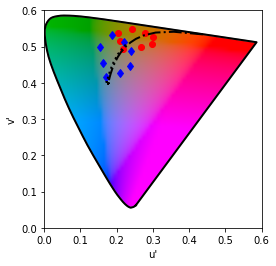

In [89]:
Yuv_TCS8_REF = lx.xyz_to_Yuv(xyz_TCS8_REF) # convert to CIE 1976 u'v'
Yuv_TCS8_REF_c = lx.xyz_to_Yuv(xyz_TCS8_REF_c) # convert to CIE 1976 u'v'

ax = plt.figure().add_subplot(111) # create figure with 1 axes

ax.plot(Yuv_TCS8_REF[:,0,1],Yuv_TCS8_REF[:,0,2],\
        color ='r',marker = 'o', linestyle = 'none')

ax.plot(Yuv_TCS8_REF_c[:,0,1],Yuv_TCS8_REF_c[:,0,2],\
        color ='b',marker ='d', linestyle = 'none')

ax.set_xlabel("u'") # set x-axis label
ax.set_ylabel("v'") # set y-axis label

lx.plotSL(cieobs = cieobs, cspace = 'Yuv', DL = True, BBL = True, diagram_colors = True, axh = ax)

## Color appearance models (.cam)

Several color appearance models (CAM), such as CIECAM02 (Moroney et al., 2002), CAM02-UCS/LCD/SCD (Luo, Cui, & Li, 2006), CAM16 & CAM16-UCS/LCD/SCD(Li et al., 2017), CAM15u (Withouck, Smet, Ryckaert, & Hanselaer, 2015), CAM18sl (Hermans, Smet, Hanselaer, 2018), CAMSWW2016(Kevin A G Smet, Webster, & Whitehead, 2016), have been implemented. In this section, the use of the `xyz_to_jab…` type wrapper functions will be demonstrated. 

For example, let’s look at the conversion from XYZ tristimulus value to CIECAM02 J,aM,bM coordinates (Similar functionality is supported for the other CAMs):

Text(0.5, 0, "b'")

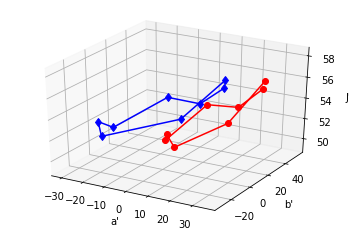

In [11]:
# Use default conditions (see lx.cam._CAM_DEFAULT_CONDITIONS)
JabM_TCS8_REF = lx.xyz_to_jabM_ciecam02(xyz_TCS8_REF) # Use default conditions

# Create a dictionary with user defined viewing conditions:
user_conditions = {'D': None, 'Dtype': None,\
                   'La': 500.0, 'Yb': 40.0, 'surround': 'dim'} 
JabM_TCS8_REF_user = lx.xyz_to_jabM_ciecam02(xyz_TCS8_REF, xyzw = xyz_REF,\
                                             conditions = user_conditions)

# Plot color coordinates contained in both arrays in a 3-dimensional graph:
ax = plt.figure().add_subplot(111,projection = '3d')

ax.plot(JabM_TCS8_REF[:,0,1], JabM_TCS8_REF[:,0,2],\
        JabM_TCS8_REF[:,0,0], color = 'r', marker = 'o')
ax.plot(JabM_TCS8_REF_user[:,0,1], JabM_TCS8_REF_user[:,0,2],\
        JabM_TCS8_REF_user[:,0,0], color ='b', marker ='d')

ax.set_zlabel("J'")
ax.set_xlabel("a'")
ax.set_ylabel("b'")

## Color difference calculation, MacAdam and Friele discrimination ellipses (.deltaE)

The `deltaE` sub-package supports calculation of color differences in various color spaces or color appearance spaces.

The widely used DE2000 color difference formula has been implemented and supports direct input of tristimulus values or CIE 1976 L\*a\*b\* color coordinates. For example, let's calculate the color difference between the color samples illuminated by the first and last light source spectrum in `REF`.

In [29]:
# Calculate DE2000:
DE00 = lx.deltaE.DE2000(xyz_TCS8_REF[:,0,:], xyz_TCS8_REF[:,-1,:], xyzwt = xyz_REF[:1,:], xyzwr = xyz_REF[-1:,:])

# Calculate DE2000 and output rms average:
DE00i, DE00a = lx.deltaE.DE2000(xyz_TCS8_REF[:,0,:], xyz_TCS8_REF[:,-1,:], xyzwt = xyz_REF[:1,:], xyzwr = xyz_REF[-1:,:],\
                       avg = lx.math.rms, out ='DEi,DEa', KLCH = [1,1,1])

# Calculate DE2000 and output rms average, but ignore L* and double the kC scaling factor:
DE00i_ab, DE00a_ab = lx.deltaE.DE2000(xyz_TCS8_REF[:,0,:], xyz_TCS8_REF[:,-1,:], xyzwt = xyz_REF[:1,:], xyzwr = xyz_REF[-1:,:],\
                       avg = lx.math.rms, out ='DEi,DEa', KLCH = [1,2,1], DEtype = 'ab')

The function DE_camucs supports calculation of color differences in color appearance spaces (CIECAM02, CAM16, CAM02ucs, CAM16lcd, ...):

In [30]:
# Calculate DE in CIECAM02 using default CAM viewing conditions:
DEi_ciecam02 = lx.deltaE.DE_camucs(xyz_TCS8_REF[:,0,:], xyz_TCS8_REF[:,-1,:], xyzwt = xyz_REF[:1,:], xyzwr = xyz_REF[-1:,:],\
                       out ='DEi', camtype ='ciecam02', ucstype ='none')

# Calculate DE in CAM02-ucs using default CAM viewing conditions:
DEi_cam02ucs = lx.deltaE.DE_camucs(xyz_TCS8_REF[:,0,:], xyz_TCS8_REF[:,-1,:], xyzwt = xyz_REF[:1,:], xyzwr = xyz_REF[-1:,:],\
                       out ='DEi', camtype ='ciecam02', ucstype ='ucs')

# Calculate DE in CAM16-lcd using default CAM viewing conditions:
DEi_cam16lcd = lx.deltaE.DE_camucs(xyz_TCS8_REF[:,0,:], xyz_TCS8_REF[:,-1,:], xyzwt = xyz_REF[:1,:], xyzwr = xyz_REF[-1:,:],\
                       out ='DEi', camtype ='cam16', ucstype ='lcd')

A handy function, `DE_cspace()`, exists that can calculate DE2000, CAMUCS-type color differences, but also color differences in any color space or chromaticity diagram for which the function `xyz_to_...` is defined. The input arguments are as before, with the additional argument `'tf'` specifying the color difference type (i.e. `'DE2000'` or `'camucs'`) or color space (e.g. `'Yuv'` or `'lab'`). When `'tf'` is different from `'DE2000'` or `'camucs'`, there is the possibility of using the `KLCH` argument to specify different weights for the lightness, chroma and hue dimensions.

In [31]:
# DE2000:
DEi_2000 = lx.deltaE.DE_cspace(xyz_TCS8_REF[:,0,:], xyz_TCS8_REF[:,-1,:], xyzwt = xyz_REF[:1,:], xyzwr = xyz_REF[-1:,:],\
                       out ='DEi', tf = 'DE2000')

# DE CAM02-ucs:
DEi_cam02ucs = lx.deltaE.DE_cspace(xyz_TCS8_REF[:,0,:], xyz_TCS8_REF[:,-1,:], xyzwt = xyz_REF[:1,:], xyzwr = xyz_REF[-1:,:],\
                       out ='DEi', camtype ='ciecam02', ucstype ='ucs', tf = 'camucs')

# DE CIE 1976 L*a*b*:
DEi_lab = lx.deltaE.DE_cspace(xyz_TCS8_REF[:,0,:], xyz_TCS8_REF[:,-1,:], xyzwt = xyz_REF[:1,:], xyzwr = xyz_REF[-1:,:],\
                       out ='DEi', tf = 'lab')

# DE CIE 1976 L*a*b* with kL, kC and kH weights different from unity (KLCH = [2,3,4]):
DEi_lab_KLCH = lx.deltaE.DE_cspace(xyz_TCS8_REF[:,0,:], xyz_TCS8_REF[:,-1,:], xyzwt = xyz_REF[:1,:], xyzwr = xyz_REF[-1:,:],\
                       out ='DEi', tf = 'lab', KLCH = [2,3,4])

MacAdam ellipses of `nsteps = 10` can be obtained and plotted in the CIE 1976 *u'v'* chromaticity diagram as follows. First, the ellipse descriptors (v-format: [Rmax, Rmin, xc,yc,theta]) of all 25 MacAdam ellipses (size: x10 as set by the `nstep` parameter) are obtained in the CIE 1931 xy space. Then a CIE 1976 *u'v'* chromaticity diagram with diagram colors is created and the axes handle is returned by the `plotSL()` function. Next, the ellipses are plotted in the CIE 1976 *u'v'* diagram in the axes with handle `axh`. The `line_style`, `line_color` and `line_width` of the ellipse boundaries are also specified.

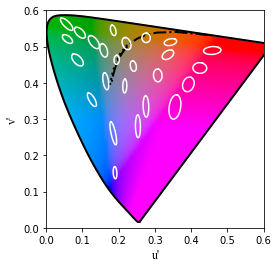

In [32]:
# Get all 25 MacAdam ellipses scaled to nsteps:
v_mac = lx.deltaE.get_macadam_ellipse(nsteps = 10)

# Plot ellipse in u'v' chromaticity diagram:
axh = lx.plotSL(show = False, diagram_colors = True, cspace = 'Yuv')
lx.plotellipse(v_mac, axh = axh, show = True, cspace_out = 'Yuv',\
            line_style = '-', line_color ='w', line_width = 1.5)

The MacAdam ellipse(s) for one or more chromaticity points, not originally investigated by MacAdam, can also be estimated (also see the approaches based on Friele coefficients in Chickering (1967, 1971) illustrated below!). 

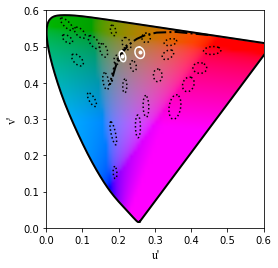

In [33]:
# Set test points chromaticities:
xy_test = np.asarray([[2/5, 1/3],[1/3,1/3]]) 

# Estimate Macadam ellipses:
v_mac_est = lx.deltaE.get_macadam_ellipse(xy = xy_test, nsteps = 10)

# Plot 25 MacAdam original ellipses (black) and estimated ellipses (white) in u'v' chromaticity diagram:
axh = lx.plotSL(show = False, diagram_colors = True, cspace = 'Yuv')
lx.plotellipse(v_mac, axh = axh, show = True, cspace_out = 'Yuv',\
            line_style = ':', line_color ='k', line_width = 1.5)
lx.plotellipse(v_mac_est, axh = axh, show = True, cspace_out = 'Yuv',\
            line_style = '-', line_color ='w', line_width = 1.5,\
            plot_center = True, center_marker = '.', center_color = 'w', center_markersize = 6)

Chickering (1967, 1971) published two methods based on Friele coefficients (FMC-1 & FMC-2, resp.) to estimate the XYZ and Yxy discrimination ellipsoids. The covariance matrices describing the ellipsoids for a set of center coordinates Yxys can be obtained as follows:

In [81]:
# Set ellipsoid centers:
Yxys = np.array([[100, 1/3, 1/3],[50, 2/3, 1/3]])

# Get matrix for XYZ ellipsoids using FMC-2:
Cij = lx.deltaE.get_gij_fmc(Yxys, etype = 'fmc2', cspace = 'xyz')
print('Cij of 1st XYZ ellipsoid:')
print(Cij[0])

# Get matrix for Yxy ellipsoids using FMC-2:
gij = lx.deltaE.get_gij_fmc(Yxys, etype = 'fmc2', cspace = 'Yxy')
print('\ngij of 1st Yxy ellipsoid:')
print(gij[0])

Cij of 1st XYZ ellipsoid:
[[1.6031e+01 1.4278e+00]
 [-1.4939e+01 -4.8994e+00]
 [-7.4903e-01 -1.1874e-15]]

gij of 1st Yxy ellipsoid:
[[9.0270e-01 2.7757e+01 -4.0058e+01]
 [2.7757e+01 2.9546e+06 -1.3060e+06]
 [-4.0058e+01 -1.3060e+06 1.1138e+06]]


The xy-covariance ellipse can be obtained as follows: 

In [82]:
# Get matrix for Yxy ellipsoids using FMC-2:
gij_ellipse = lx.deltaE.get_gij_fmc(Yxys, etype = 'fmc2', cspace = 'Yxy',ellipsoid=False)
print('gij of 1st xy-ellipse:')
print(gij_ellipse[0])

gij of 1st xy-ellipse:
[[2.9546e+06 -1.3060e+06]
 [-1.3060e+06 1.1138e+06]]


These can than be converted to an array with [Rmax, Rmin, xc, yc, theta] (v-format) using `lx.math.cik_to_v()`:

In [83]:
v_ellipses = lx.math.cik_to_v(gij_ellipse, xyc = Yxys[:,1:])
print('v_ellipse with [Rmax, Rmin, xc, yc, theta] for both center coordinates:')
print(v_ellipses)

v_ellipse with [Rmax, Rmin, xc, yc, theta] for both center coordinates:
[[1.5136e-03 5.2472e-04 3.3333e-01 3.3333e-01 1.0924e+00]
 [1.5798e-03 1.0046e-03 6.6667e-01 3.3333e-01 4.8245e-01]]


Estimates of n-step discrimination ellipses (in v-format) using either:
    1. the interpolation between `k_neighbors` nearest MacAdamn ellipses (as illustrated earlier), or 
    2. the FMC-1 or FMC-2 methods described by Chickering (1967, 1971)
can also be obtained directly using the `get_discrimination_ellipse()` function:

In [84]:
v_macadam = lx.deltaE.get_discrimination_ellipse(Yxy = Yxys, etype = 'macadam', nsteps = 10)
v_fmc1 = lx.deltaE.get_discrimination_ellipse(Yxy = Yxys, etype = 'fmc1', nsteps = 10)
v_fmc2 = lx.deltaE.get_discrimination_ellipse(Yxy = Yxys, etype = 'fmc2', nsteps = 10, Y = 10.69) 
print('v_macadam:')
print(v_macadam)
print('v_fmc1:')
print(v_fmc1)
print('v_fmc2:')
print(v_fmc2)

v_macadam:
[[2.7069e-02 1.1116e-02 3.3333e-01 3.3333e-01 1.1530e+00]
 [2.5448e-02 1.3009e-02 6.6667e-01 3.3333e-01 3.2076e-01]]
v_fmc1:
[[3.2464e-02 1.1275e-02 3.3333e-01 3.3333e-01 1.0908e+00]
 [2.7889e-02 1.7244e-02 6.6667e-01 3.3333e-01 4.8685e-01]]
v_fmc2:
[[3.2558e-02 1.1287e-02 3.3333e-01 3.3333e-01 1.0924e+00]
 [2.7892e-02 1.7744e-02 6.6667e-01 3.3333e-01 4.8237e-01]]


Note that only for Y=10.69 (relative to Yw=100) will FMC-2 result in an approximation of FMC-1 and the MacAdam ellipses (also see code block below), as the ellipse sizes in FMC-2 are dependent on the relative luminance factor Y!

The code below calculates the FMC-1 and FMC-2 ellipses for all 25 MacAdam centers and plots the results (blue and green, resp.) together with the original MacAdam ellipses (red):

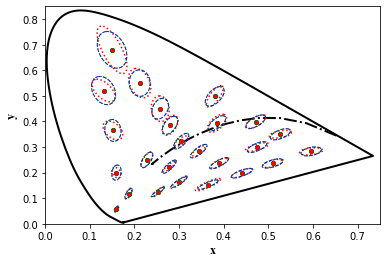

In [85]:
# Get MacAdam ellipse data:
v_mac = lx.deltaE.get_macadam_ellipse(xy = None)
xys = v_mac[:,2:4] # select center coordinates

# Get discrimination ellipses for using FMC-1 & FMC-2:
v_mac_1 = lx.deltaE.get_discrimination_ellipse(Yxy = xys, etype = 'fmc1', nsteps = 10)
v_mac_2 = lx.deltaE.get_discrimination_ellipse(Yxy = xys, etype = 'fmc2', nsteps = 10, Y = 10.69)

# Plot results:
axh = lx.plotSL(cspace = 'Yxy', cieobs = '1931_2', show = False, diagram_colors = False)
axh = lx.plotellipse(v_mac, axh = axh, plot_center = False,  out = 'axh', line_style = ':', line_color ='r', line_width = 1.5, center_color = 'r')
lx.plotellipse(v_mac_1,  axh = axh,  line_color = 'b', line_style = '--', plot_center = True, center_color = 'b')
lx.plotellipse(v_mac_2,  axh = axh,  line_color = 'g', line_style = ':', plot_center = True, center_color = 'g')

axh.set_xlim([0,0.75])
axh.set_ylim([0,0.85])
plt.plot(xys[:,0],xys[:,1],'r.')

The statistical signifance of the difference between two (sets of) coordinate centers (based on Hotelling's T2 test statistic calculated based on the discrimination ellipses) can be determined as follows:

T2 values:  [0.0000e+00 0.0000e+00 5.2691e+00 1.4075e+00 7.5987e+00]
p-values:  [1.0000e+00 1.0000e+00 7.1752e-02 4.9473e-01 2.2386e-02]
p < 0.05:  [False False False False  True]

 Ellipse 95%-scale-factor =  2.447746830680816


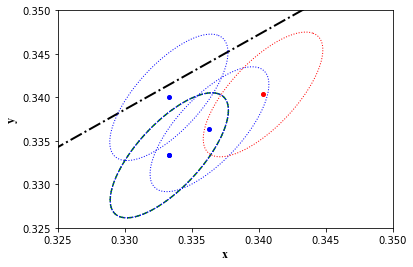

In [86]:
Yxy1 = np.array([[100,1/3,1/3]])
Yxy2 = np.array([[100,1/3, 1/3],
                 [50,1/3,1/3],
                 [100,0.3333,0.34],
                 [50,1/3+ 0.003,1/3 + 0.003], 
                 [50,1/3 + 0.007,1/3 + 0.007]])
p,T2 = lx.deltaE.discrimination_hotelling_t2(Yxy1,Yxy2, Y1 = 10.69, Y2=10.69, etype = 'fmc2', ellipsoid = False, cspace = 'Yxy')
print('T2 values: ', T2)
print('p-values: ', p)
print('p < 0.05: ', p < 0.05)

# Plot 95% discrimination ellipses:
v1 = lx.deltaE.get_discrimination_ellipse(Yxy = Yxy1, etype = 'fmc2', nsteps = 1, Y = 10.69) # v for 1-step ellipse
v2 = lx.deltaE.get_discrimination_ellipse(Yxy = Yxy2, etype = 'fmc2', nsteps = 1, Y = 10.69) # v for 1-step ellipse
scale = lx.utils.sp.stats.chi2.ppf(1-0.05,2)**0.5 # get scale factor for 95% confidence ellipses
print('\n Ellipse 95%-scale-factor = ', scale)
v1[:,:2] *= scale
v2[:,:2] *= scale

axh = lx.plotSL(cspace = 'Yxy', cieobs = '1931_2', show = False, diagram_colors = False)
axh = lx.plotellipse(v1, axh = axh, plot_center = False,  out = 'axh', line_style = '--', line_color ='g', line_width = 1.5, center_color = 'g')
for i in range(v2.shape[0]):
    color = 'r' if p[i] < 0.05 else 'b'
    lx.plotellipse(v2[i:i+1,:],  axh = axh,  line_color = color, line_style = ':', plot_center = True, center_color = color)
axh.set_xlim([0.325,0.35]);
axh.set_ylim([0.325,0.35]);


## Color rendition measures (.cri)

The `cri` sub-package supports several color rendition metrics, such as CIE13.3-1995 Ra (CIE13.3-1995, 1995), CIE224-2017 Rf (CIE224:2017, 2017), IESTM30 Rf and Rg (David et al., 2015; IES, 2015; IES, 2018), CRI2012 (K. Smet, Schanda, Whitehead, & Luo, 2013), MCRI (K A G Smet, Ryckaert, Pointer, Deconinck, & Hanselaer, 2012) and CQS (Davis & Ohno, 2010). It also contains handy functions to construct ‘new’ color fidelity type metrics very easily by changing for example the sample set, averaging method, color space, CIE observer, …

Finally, a sub-package `cri.VFPX` also supports the calculation of vector field based and pixel based color shifts, of a metameric uncertainty index, …
Wrapper functions have been created specifically dedicated to the standard definition of the published color rendition measures. They can be calculated as follows:


In [2]:
# First get some spectra from the IESTM30 light source database:
spds = lx._IESTM3018['S']['data'][:4+1] # N = 4

ciera = lx.cri.spd_to_ciera(spds) # CIE13.3-1995 Ra
cierf = lx.cri.spd_to_cierf(spds) # CIE224-2017 Rf
iesrf_15 = lx.cri.spd_to_iesrf(spds, cri_type = 'iesrf-tm30-15') # IES-TM30-15 Rf
iesrg_15 = lx.cri.spd_to_iesrg(spds, cri_type = 'iesrf-tm30-15') # IES-TM30-15 Rg
iesrf_18 = lx.cri.spd_to_iesrf(spds) # IES-TM30-18 Rf
iesrg_18 = lx.cri.spd_to_iesrg(spds) # IES-TM30-18 Rg
print('CIE 13.3-1995 Ra:')
print(ciera)
print('CIE224-2017 Rf:')
print(cierf)
print('IES TM30-15 Rf:')
print(iesrf_15)
print('IES TM30-15 Rg:')
print(iesrg_15)
print('IES TM30-18 Rf:')
print(iesrf_18)
print('IES TM30-18 Rg:')
print(iesrg_18)

CIE 13.3-1995 Ra:
[[7.5859e+01 6.4237e+01 5.6789e+01 5.1478e+01]]
CIE224-2017 Rf:
[[8.0684e+01 7.0209e+01 6.3197e+01 5.6836e+01]]
IES TM30-15 Rf:
[[7.8360e+01 6.7130e+01 5.8778e+01 5.1664e+01]]
IES TM30-15 Rg:
[[8.9832e+01 8.6409e+01 8.4414e+01 8.3538e+01]]
IES TM30-18 Rf:
[[8.0684e+01 7.0209e+01 6.3197e+01 5.6836e+01]]
IES TM30-18 Rg:
[[8.9829e+01 8.6440e+01 8.4412e+01 8.3536e+01]]


The use of the more versatile `spd_to_cri` function allows the calculation a color fidelity value using all the same standard parameters as those of the metric defined in `cri_type`, but with for example a change of the sample set from the IES99 to the IES4880, using a blackbody radiator as reference illuminant and using the rms instead of the mean to average the color differences before calculating the general color fidelity index. Requested output can be specified by a string using `out`: 

In [3]:
Rf_custom, Rg_custom, cct, duv = lx.cri.spd_to_cri(spds, cri_type = 'ies-tm30',\
                             out = 'Rf,Rg,cct,duv', avg = lx.math.rms,\
                             sampleset = lx._CRI_RFL['ies-tm30']['4880']['5nm'],\
                             ref_type = 'BB')
print('Rf_custom:')
print(Rf_custom)
print('Rg_custom:')
print(Rg_custom)
print('cct:')
print(cct)

Rf_custom:
[[7.7483e+01 6.7108e+01 5.9424e+01 5.2895e+01]]
Rg_custom:
[[8.8549e+01 8.6448e+01 8.4454e+01 8.3509e+01]]
cct:
[[6.4248e+03]
 [4.2247e+03]
 [3.4470e+03]
 [2.9393e+03]]


The `luxpy.cri` sub-package also supports a function that calculates several color rendition index values and provides TM30-like graphical output:

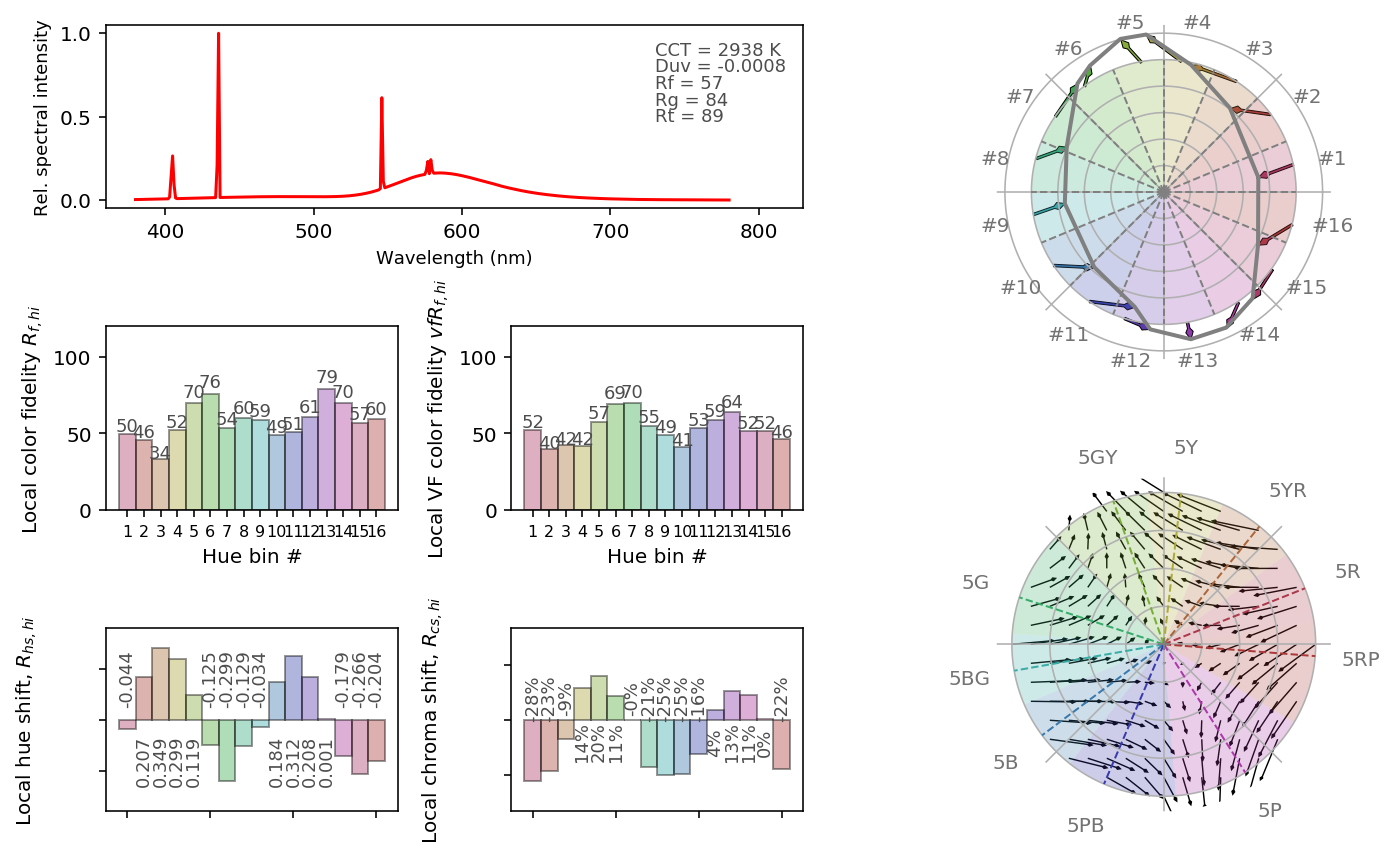

In [4]:
# Calculate and plot IES TM30 color rendition measures:
SPD = lx._CIE_ILLUMINANTS['F4']
data, _, _ = lx.cri.plot_cri_graphics(SPD)

The output format of and displayed information in some of the right hand graphs can be easily customized. For example the following code uses only 8 hue bins (cfr. CIE224-2017), turns off the coloring of the right-hand side color icons, plots the vector field base color shifts in grey and plots the distortion of the color gamut using circle fields (the color of the distorted circles provides information on the size of the hue shift, red being larger). In the top-right color vector graphic the coordinates of the samples under the test illuminant relative to the mean chromaticity under the reference illuminant are also plotted:

Keys in dictionary with color rendition data:
dict_keys(['SPD', 'cct', 'duv', 'bjabt', 'bjabr', 'jabti', 'jabri', 'hbinnr', 'Rf', 'Rg', 'Rfi', 'Rfhi', 'Rcshi', 'Rhshi', 'Rt', 'Rti', 'Rfhi_vf', 'Rfcshi_vf', 'Rfhshi_vf', 'dataVF', 'cri_type'])


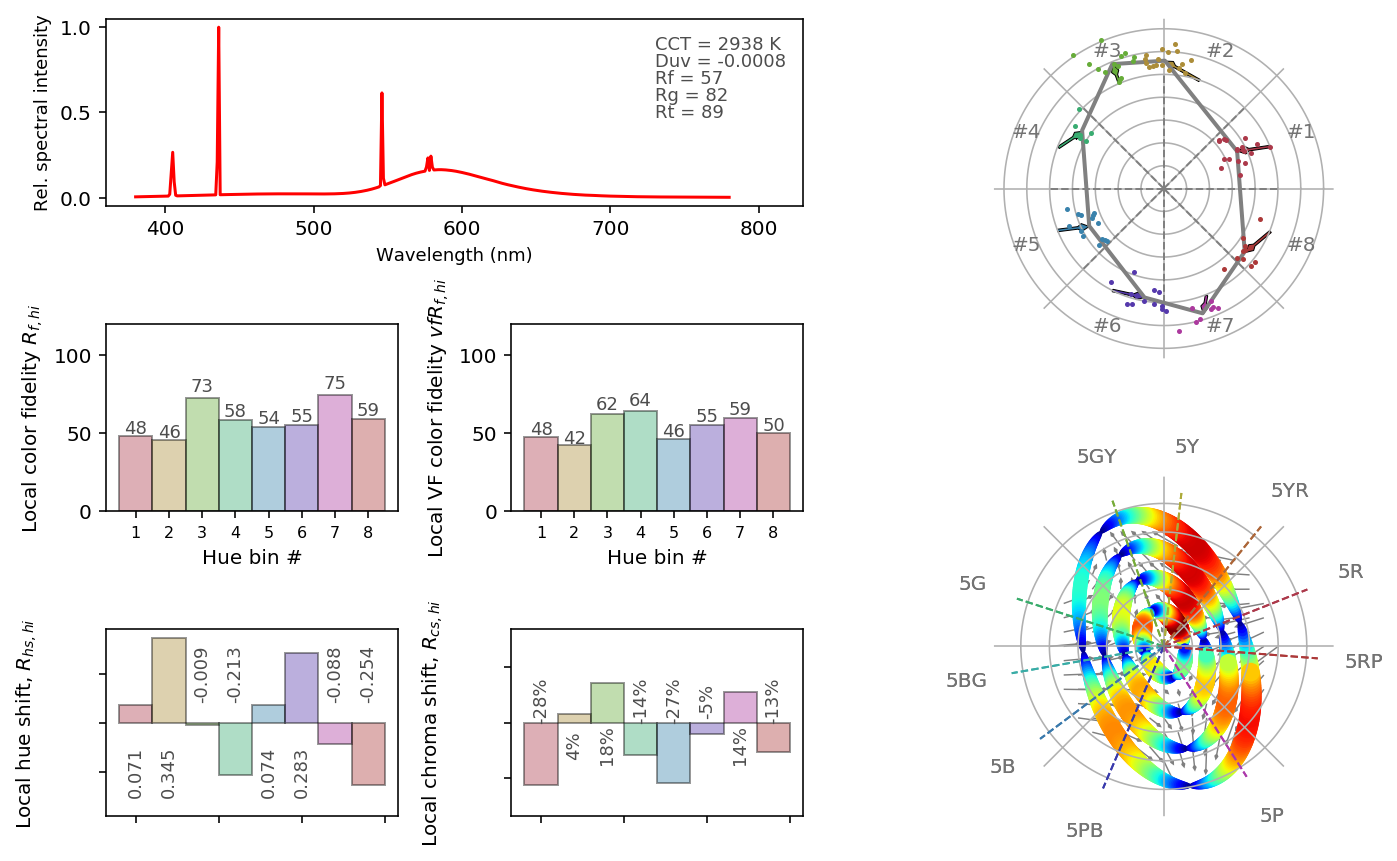

In [5]:
# Customized graphical color rendition output:
data, _, _ = lx.cri.plot_cri_graphics(SPD, plot_bin_colors = False, \
                                vf_plot_bin_colors = False,\
                                vf_color = 'grey', plot_CF = True, 
                                plot_test_sample_coord = True,
                                hbins = 8)
print("Keys in dictionary with color rendition data:")
print(data.keys())

A **Color Rendition Report** as recommended by ANSI/IES-TM30-2018 can be generated with `plot_tm30_report()`:

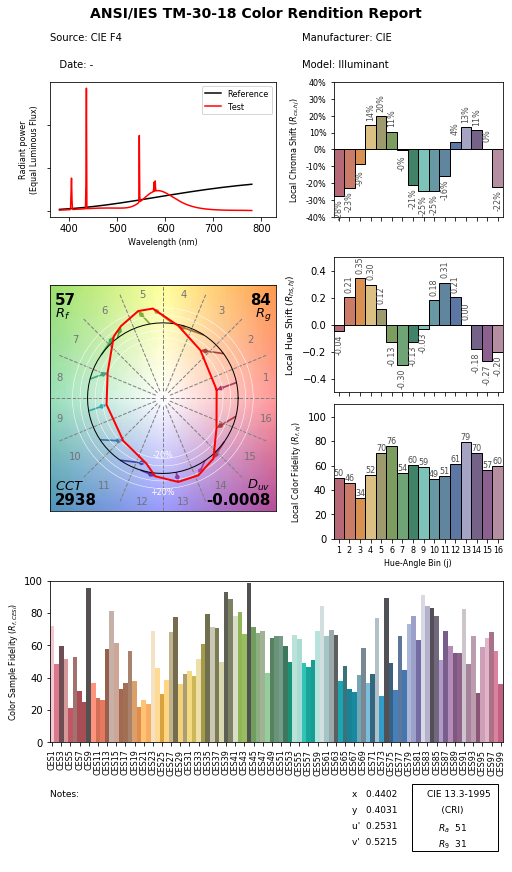

In [6]:
lx.cri.plot_tm30_report(SPD, cri_type = 'ies-tm30', source = 'CIE F4', manufacturer = 'CIE', model = 'Illuminant', date = '-');

The `_tm30_process_spd()` function is used by `plot_tm30_report()` and the functions below as it generates a dictionary with color rendition and colorimetric data calculated from a (single) spectral power distribution:

In [7]:
data = lx.cri._tm30_process_spd(SPD)
print('data dict keys:', data.keys())

data dict keys: dict_keys(['spd', 'Rf', 'Rg', 'cct', 'duv', 'Sr', 'cri_type', 'xyzri', 'xyzrw', 'hbinnrs', 'Rfi', 'Rfhi', 'Rcshi', 'Rhshi', 'jabt_binned', 'jabr_binned', 'nhbins', 'start_hue', 'normalize_gamut', 'scalef'])


Individual graphs from the TM30 report can be created with following functions: `plot_tm30_cvg()`,`plot_tm30_Rfi()`,`plot_tm30_Rxhj()`,`plot_tm30_Rcshj()`,`plot_tm30_Rhshj()`,`plot_tm30_Rfhj()`,`plot_tm30_spd()`.

#### plot_tm30_cvg():

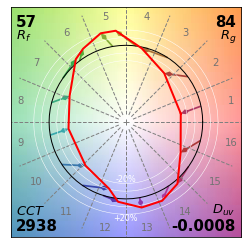

In [8]:
lx.cri.plot_tm30_cvg(SPD);

#### plot_tm30_Rfi():

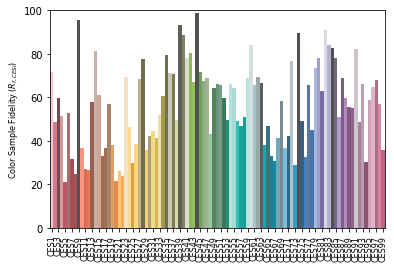

In [9]:
lx.cri.plot_tm30_Rfi(SPD);

#### plot_tm30_Rxhj()

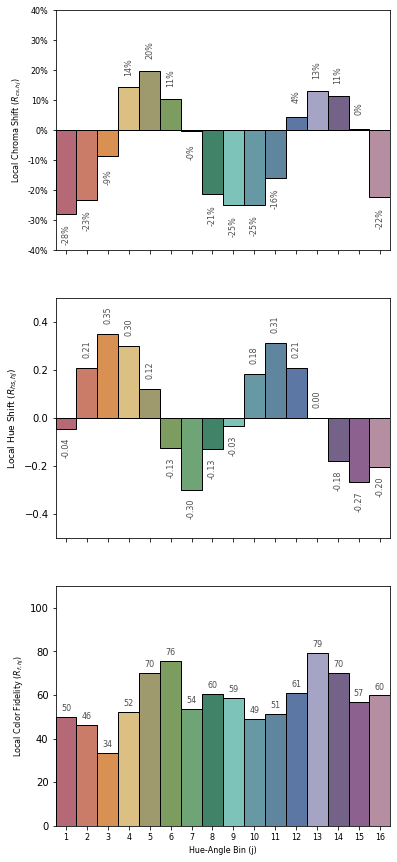

In [10]:
lx.cri.plot_tm30_Rxhj(SPD);

## Spectral and colorimetric data using LuxPy classes

Spectral and colorimetric data also have their own dedicated classes which have basic functionality by providing class method wrappers to some of the LuxPy functions. 

An instance of the class `SPD` can be created by initiating it directly with a `NumPy.ndarray` or by providing the path to a datafile as input. Using the `spds` data array specified above (containing blackbody radiator and daylight phase spectra of 4500 K):

In [72]:
spds = lx.cri_ref([4500,4500], ref_type = ['BB','DL'], wl3 = [380,780,5]) 
spds_inst = lx.SPD(spds)

The advantage of the creating such an `SPD` instance is that it is easy to store some additional specific info related to the data:

In [73]:
print("Spectral data type is stored in .dtype field: {}".format(spds_inst.dtype))
print("Wavelength are in .wl field: {}".format(spds_inst.wl.shape))
print("Value are in .value field: {}".format(spds_inst.value.shape))
print("Number of spds is contained in .N field: {}".format(spds_inst.N))
print("Shape of REFo.value is in .shape field: {}".format(spds_inst.shape)) 

Spectral data type is stored in .dtype field: S
Wavelength are in .wl field: (81,)
Value are in .value field: (2, 81)
Number of spds is contained in .N field: 2
Shape of REFo.value is in .shape field: (2, 81)


And it especially allows for very readable code, when performing several operations in sequence:

In [74]:
xyz_inst = lx.SPD(spds).cie_interp(wl_new = [400, 700, 5]).normalize(norm_type = 'area').to_xyz()

The code above produced an instance of class `XYZ`, `xyz_inst`, which itself has several methods for easy use. The further conversion to CIELUV L\*u\*v\* coordinates, with assumed white point the equi-energy white, can for example be done as follows:

In [75]:
luv_inst = xyz_inst.ctf(dtype = 'luv', xyzw = np.array([[100, 100, 100]]))

In each instance, the field `value` contains the actual data. For the SPD class, this is the spectral data stripped of its wavelengths (contained in a `wl` field), for the `XYZ` and `LAB` classes, this is an array with the tristimulus values and specified colorimetric data, respectively. For the latter a field called `dtype` keeps track of what type of data (e.g. `'xyz'`, `'Yuv'`, `'luv'`, …) the instance contains. In addition to a field `cieobs`, which specifies the CMF set used, instances of the class `LAB` also contain a field `cspace_par` that contains a Python dictionary with a set of parameters (e.g. `'xyzw'`) relevant to the calculation of the colorimetric values. 

In [76]:
print(luv_inst.cspace_par)

{'cieobs': '1931_2', 'xyzw': array([[100, 100, 100]]), 'M': None, 'scaling': None, 'Lw': None, 'Yw': None, 'Yb': None, 'conditions': None, 'yellowbluepurplecorrect': None, 'mcat': None, 'ucstype': None, 'fov': None, 'parameters': None}


Each class also contains a basic plotting method for a quick look at the data contained in the instance:

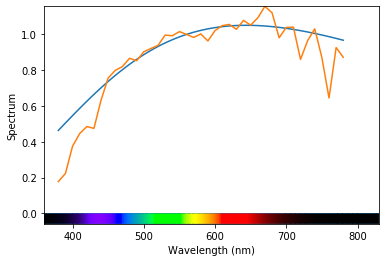

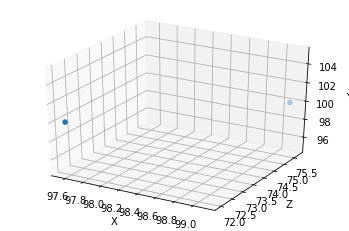

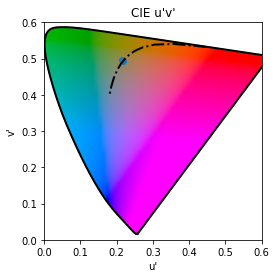

In [77]:
spds_inst.plot() #class SPD
xyz_inst.plot() #class XYZ
xyz_inst.ctf(dtype = 'Yuv').plot(plt_type = '2d', title = "CIE u'v'") #class LAB
lx.plotSL(diagram_colors = True, axh = plt.gca()) # plots spectrum locus

## Calculation of photo-biological quantities (.photbiochem)

Sub-package `.photbiochem` supports the calculation of various photo-biological or related quantities, such as the Cyanosis Observation Index (COI)[AS/NZS1680.2.5 1997], the CIE photobiological quantities (α-opic irradiance and equivalent illuminance) defined in TN003:2015 [CIE-TN003:2015 2015; Lucas 2014] or the LRC’s Circadian Stimulus (CS) and Circadian Lighting (CLa) [Rea 2012] from spectral data. 

Let’s start with the TN003:2015 α-actinic quantities, for which a single dedicated function has been implemented: `spd_to_aopicE()`. The input spectral irradiance can be in W/m²∙nm (default) or in μW/cm²∙nm. The output is in SI units.

In [78]:
# Define a 4200 K blackbody radiator:
sid = lx.blackbody(4200, lx.getwlr([378,782,1]))

# Calculate the a-opic irradiance Eea and equivalent illuminance Ee for the blackbody radiator normalized to 100 lx:
Ees,Es = lx.photbiochem.spd_to_aopicE(sid, E = 100)

# Print results:
print("Photoreceptor cells:")
print(lx.photbiochem._PHOTORECEPTORS)
print("\na-opic irradiance symbols:")
print(lx.photbiochem._Ee_SYMBOLS)
print("a-opic irradiance units:")
print(lx.photbiochem._Ee_UNITS)
print("a-opic irradiance values:")
print(Ees)
print("\na-opic illuminance symbols:")
print(lx.photbiochem._E_SYMBOLS)
print("a-opic illuminance units:")
print(lx.photbiochem._E_UNITS)
print("a-opic illuminance values:")
print(Es)

Photoreceptor cells:
['l-cone', 'm-cone', 's-cone', 'rod', 'iprgc']

a-opic irradiance symbols:
['Ee,lc', 'Ee,mc', 'Ee,sc', 'Ee,r', 'Ee,z']
a-opic irradiance units:
['W⋅m−2', 'W⋅m−2', 'W⋅m−2', 'W⋅m−2', 'W⋅m−2']
a-opic irradiance values:
[[1.2314e+00 1.0892e+00 3.5702e-01 8.7752e-01 7.0344e-01]]

a-opic illuminance symbols:
['E,lc', 'E,mc', 'E,sc', 'E,r', 'E,z']
a-opic illuminance units:
['lux', 'lux', 'lux', 'lux', 'lux']
a-opic illuminance values:
[[7.1277e+02 6.7535e+02 4.7313e+02 6.1897e+02 5.8555e+02]]


The following code snippet illustrates the use of the `spd_to_COI_ASNZS1680()` function that calculates the COI and can also output the CCT:

In [79]:
# Get a light source spectrum:
F4 = lx._CIE_ILLUMINANTS['F4']

# Calculate COI and CCT:
coi, cct = lx.photbiochem.spd_to_COI_ASNZS1680(F4) 

The Circadian Stimulus (CS) and Circadian Light (CLa) quantities of a (set of) light source(s) can be calculated as follows: 

In [80]:
from luxpy.toolboxes.photbiochem import spd_to_CS_CLa_lrc
# Get a set of 3 light source spectra:
S = lx._IESTM3018['S']['data'][:4]

# Calculate CS and CLa:
CS1, CLa1 = spd_to_CS_CLa_lrc(El = S)

# The same, but this time with all 
# 3 normalized to 100 lx:
CS2, CLa2 = spd_to_CS_CLa_lrc(El = S,\
                             E = 100)


# Or to different illuminance values: 
CS3, CLa3 = spd_to_CS_CLa_lrc(El = S,\
                      E = [100, 200, 50])

# The input spectra can also be summed to generate a composite spectrum for which the CS and CLa will be calculated:
CS4, CLa4 = spd_to_CS_CLa_lrc(El = S,\
                      E = [100, 200, 50],\
                      sum_sources = True)

# Print results:
print('CS1, CLa1:')
print(CS1,CLa1)
print('\nCS2, CLa2:')
print(CS2,CLa2)
print('\nCS3, CLa3:')
print(CS3,CLa3)
print('\nCS4, CLa4:')
print(CS4,CLa4)

CS1, CLa1:
[6.9862e-01 6.9803e-01 6.9710e-01] [1.0095e+05 7.3051e+04 5.1294e+04]

CS2, CLa2:
[1.7518e-01 9.3232e-02 4.7315e-02] [1.3149e+02 6.5061e+01 3.2918e+01]

CS3, CLa3:
[1.7518e-01 1.7478e-01 2.2740e-02] [1.3149e+02 1.3113e+02 1.6379e+01]

CS4, CLa4:
[3.0622e-01] [2.8316e+02]


## Creating and optimizing multi-component spectra (.spdbuild)

The `.spdbuild` sub_package supports creating Gaussian, monochromatic (Ohno, 2005) and phosphor LED-type (Smet et al. 2011) spectra, and combining them to multi-component spectra. It also supports automatic flux calculations to obtain a desired spectrum chromaticity. Additional objective functions can also be used to optimize the component fluxes to these additional constraints. This section will only briefly introduce some of its features. For more info the reader is referred to the `__doc__` strings of the module functions.

The toolboxes can be import for example as:

In [2]:
import luxpy.toolboxes.spdbuild as spb 

### 1. spd_builder() 

### 1.1 spd_builder():  monochromatic led mixtures
As a first example, let’s start with the creation of 4 monochromatic LEDs: 


[[1.0000e+02 2.1053e-01 4.7366e-01]]
[[1.0000e+02 2.1053e-01 4.7366e-01]]


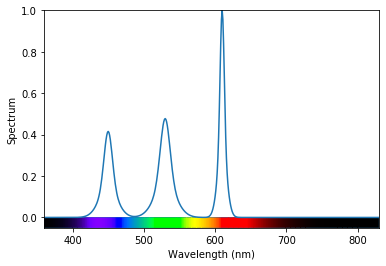

In [3]:
# Set peak wavelengths:
peakwl = [450,530,610]

# Set Full-Width-Half-Maxima:
fwhm = [30,35,15] 

E = lx._CIE_ILLUMINANTS['E']
Yuv = lx.colortf(E,'spd>Yuv')
print(Yuv)

S = spb.spd_builder(peakwl = peakwl, fwhm = fwhm,target = Yuv)

xyz = lx.spd_to_xyz(S)
Yuv2 = lx.xyz_to_Yuv(xyz)
print(Yuv2)

# Plot component spds:
lx.SPD(S).plot()

### 1.2 spd_builder():  phosphor type led
Next, let's create 2 phosphor type (one with 1 phosphor and one with 2 phosphors) and one monochromatic LEDs. 

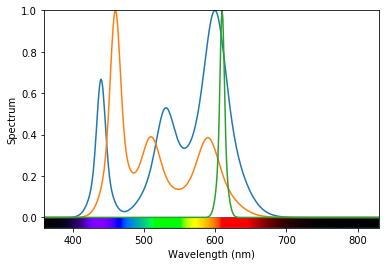

In [4]:
# Set peak wavelengths of monochromatic leds:
peakwl = [440,460,610]

# Set Full-Width-Half-Maxima of monochromatic leds:
fwhm = [30,35,15] 

# Set phosphor strengths:
strength_ph = [1.5, 0.4, 0]

# Set phosphor 1 parameters:
strength_ph1 = [1, 1, 0]
peakwl_ph1 = [530, 510, 1]
fwhm_ph1 = [60, 60, 60]

# Set phosphor 2 parameters:
strength_ph2 = [2, 1, 0]
peakwl_ph2 = [600, 590, 590]
fwhm_ph2 = [70, 70, 70]


S = spb.spd_builder(peakwl = peakwl, fwhm = fwhm,\
                    strength_ph = strength_ph, \
                    strength_ph1 = strength_ph1,\
                    peakwl_ph1 = peakwl_ph1,\
                    fwhm_ph1 = fwhm_ph1,\
                    strength_ph2 = strength_ph2,\
                    peakwl_ph2 = peakwl_ph2,\
                    fwhm_ph2 = fwhm_ph2)

# Plot component spds:
lx.SPD(S).plot()

One can also set them a specific target chromaticity, specified by `target` (`tar_type` specifies the type of target, e.g. `'cct'`, `'Yxy'`, ... and `cspace_bwtf` is a dict specifying the parameters need for the backward transformation called in `colortf()` inside `spd_builder()`). The code below calculates the fluxes required for a cct = 3500 K (Duv = 0). There are only 2 spectra plotted in the figure below as any set of 3 spectral components, i.e. monochromatic led and 2 phosphors, for which the target is out of gamut results in an array of NaN's. 

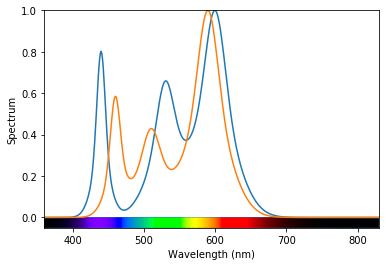

In [5]:
cieobs = '1931_2'
cspace_bwtf = {'cieobs' : cieobs, 'mode' : 'search'}
S = spb.spd_builder(peakwl = peakwl, fwhm = fwhm,\
                    strength_ph = strength_ph, \
                    strength_ph1 = strength_ph1,\
                    peakwl_ph1 = peakwl_ph1,\
                    fwhm_ph1 = fwhm_ph1,\
                    strength_ph2 = strength_ph2,\
                    peakwl_ph2 = peakwl_ph2,\
                    fwhm_ph2 = fwhm_ph2,\
                    target = 3500, tar_type = 'cct',\
                    cspace_bwtf = cspace_bwtf)

# Plot component spds:
lx.SPD(S).plot()

### 2. spd_optimizer()
### 2.1 spd_optimizer(): led mixtures with *"fixed"* peak wavelengths & FWHMs
The package also supports spectra optimization beyond the target chromaticity when there are more than 3 spectral components provided.

The following code block provides a practical example of flux optimization with fixed component spectra using objective functions for a target chromaticity of 4000 K (Duv = 0). The objective functions and their target values are specified as two lists. For this example the IES Rf and Rg measures were chosen with target values of resp. 90 and 110. The optimization is done using the `'2mixer'` optimizer (another option is `'3mixer'`). See notes in `?lx.spdbuild.spd_optimizer`. The `out` arguments sets up an output of the optimized spectrum (`'spds'`) and the component spectra (`'component_spds'`) used to build the optimized spectrum.

Optimization terminated successfully.
         Current function value: 0.029590
         Iterations: 21
         Function evaluations: 44

Results (optim,target):
cct(K): (3500.0,3500.0)
Rf: (88.01,90.00)
Rg: (107.84, 110.00)


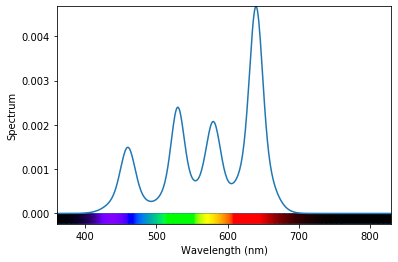

In [21]:
target = 3500
peakwl = [460,530,580,640]
fwhm = [50,45,50,45] 
obj_fcn = [lx.cri.spd_to_iesrf, lx.cri.spd_to_iesrg]
obj_tar_vals = [90,110]
S, primaries = spb.spd_optimizer(target = target, \
                          tar_type = 'cct',\
                          cspace_bwtf = cspace_bwtf,\
                          optimizer_type = '2mixer',\
                          peakwl = peakwl, \
                          fwhm = fwhm,\
                          obj_fcn = obj_fcn, \
                          obj_tar_vals = obj_tar_vals,\
                          verbosity = 0, out = 'spds,component_spds')

# Check output agrees with target:
xyz = lx.spd_to_xyz(S, relative = False, cieobs = cieobs)
cct = lx.xyz_to_cct(xyz, cieobs = cieobs, mode = 'search')[0,0]
Rf, Rg = [fcn(S)[0,0] for fcn in obj_fcn]
print('\nResults (optim,target):')
print("cct(K): ({:1.1f},{:1.1f})".format(cct, target))
print("Rf: ({:1.2f},{:1.2f})".format(Rf, obj_tar_vals[0]))
print("Rg: ({:1.2f}, {:1.2f})".format(Rg, obj_tar_vals[1]))

#plot spd:
plt.figure()
lx.SPD(S).plot()

The component spds (primaries) used to build the above spectrum are:

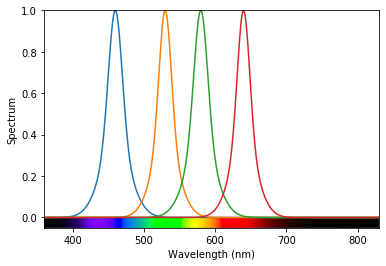

In [22]:
lx.SPD(primaries).plot()

### 2.2 spd_optimizer(): led mixtures with *"free"* peak wavelengths & FWHMs
In addition to flux-only optimization, the peak wavelengths and full-width-half-maxima of the components can also be optimized. The example below calculates a spectrum with a CCT of 4500 K (Duv = -0.005) and optimized for IES Rf and Rg having respective target values of 90 and 110.
The spectrum is build from 5 components with free peak wavelength, fwhm and fluxes.

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1311
         Function evaluations: 1995

Results (optim,target):
cct(K): (4500.0,4500.0)
Duv: (-0.005,-0.005)
Rf: (90.00,90.00)
Rg: (110.00, 110.00)


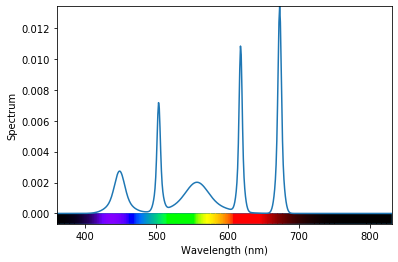

In [12]:
target = np.array([[4500, -0.005]]) # specify cct & duv!
obj_fcn = [lx.cri.spd_to_iesrf, lx.cri.spd_to_iesrg]
obj_tar_vals = [90,110]
S, _ = spb.spd_optimizer(target = target, \
                      tar_type = 'cct',\
                      cspace_bwtf = cspace_bwtf,\
                      optimizer_type = '2mixer',\
                      N_components = 5,
                      obj_fcn = obj_fcn, \
                      obj_tar_vals = obj_tar_vals,\
                      verbosity = 0)

# Check output agrees with target:
xyz = lx.spd_to_xyz(S, relative = False, cieobs = cieobs)
cct = lx.xyz_to_cct(xyz, cieobs = cieobs, mode = 'search',out='[cct,duv]')
Rf, Rg = [fcn(S)[0,0] for fcn in obj_fcn]
print('\nResults (optim,target):')
print("cct(K): ({:1.1f},{:1.1f})".format(cct[0,0], target[0,0]))
print("Duv: ({:1.3f},{:1.3f})".format(cct[0,1], target[0,1]))
print("Rf: ({:1.2f},{:1.2f})".format(Rf, obj_tar_vals[0]))
print("Rg: ({:1.2f}, {:1.2f})".format(Rg, obj_tar_vals[1]))

#plot spd:
plt.figure()
lx.SPD(S).plot()

In [13]:
cct

array([[4.5000e+03, -5.0008e-03]])

In order to avoid expensive calculations being repeated for each objective functions, e.g. as in the code above where the reference illuminant and the coordinates of the TM30 samples are calculate twice, the optimization can also be performed by defining a function that outputs all the required objective values in a vertically stacked array and then calling `spd_optimizer()` as follows:

Optimization terminated successfully.
         Current function value: 0.225053
         Iterations: 1325
         Function evaluations: 1980

Results (optim,target):
cct(K): (4500.0,4500.0)
Duv: (-0.005,-0.005)
Rf: (91.79,90.00)
Rg: (99.04, 110.00)
Ra: (89.52, 85.00)


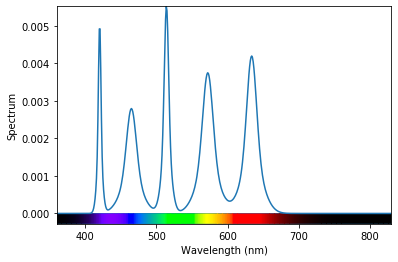

In [16]:
# Define function that outputs all objective function values:
def spd_to_tm30(spd):
    # Call function that calculates ref.illuminant and jabt & jabr only once to obtain Rf & Rg:
    Rf,Rg = lx.cri.spd_to_cri(spd, cri_type = 'iesrf', out = 'Rf,Rg') 
    return np.vstack((Rf, Rg)) 

# Specify objective functions as a list, whereby each function that has multiple outputs is defined as a tuple:
obj_fcn = [(spd_to_tm30, 'Rf','Rg'), lx.cri.spd_to_ciera]
obj_tar_vals = [(90,110), 85]
obj_fcn_weights = [(1,1), 1]
decimals = [(5,5), 5]

S, _ = spb.spd_optimizer(target = target, \
                          tar_type = 'cct',\
                          cspace_bwtf = cspace_bwtf,\
                          optimizer_type = '2mixer',\
                          N_components = 5,\
                          obj_fcn = obj_fcn, \
                          obj_tar_vals = obj_tar_vals,\
                          verbosity = 0, out = 'spds,component_spds')

# Check output agrees with target:
xyz = lx.spd_to_xyz(S, relative = False, cieobs = cieobs)
cct,duv = lx.xyz_to_cct(xyz, cieobs = cieobs, mode = 'search',out = 'cct,duv')
(Rf, Rg), Ra= obj_fcn[0][0](S), obj_fcn[1](S)[0]
print('\nResults (optim,target):')
print("cct(K): ({:1.1f},{:1.1f})".format(cct[0,0], target[0,0]))
print("Duv: ({:1.3f},{:1.3f})".format(duv[0,0], target[0,1]))
print("Rf: ({:1.2f},{:1.2f})".format(Rf[0], obj_tar_vals[0][0]))
print("Rg: ({:1.2f}, {:1.2f})".format(Rg[0], obj_tar_vals[0][1]))
print("Ra: ({:1.2f}, {:1.2f})".format(Ra[0], obj_tar_vals[1]))

#plot spd:
plt.figure()
lx.SPD(S).plot()

Note that `obj_fcn` can be a list of tuples and function handles, e.g. [(spd_to_tm30,'Rf','Rg'), lx.cri.spd_to_Ra]. When a multiple-output function is specified as a tuple, the first element is the function handle, the other elements are strings specifying the output (note that the latter are only used for printing output! The user is reponsible for specifying the correct order in the tuple). The variables `obj_fcn_weights`, `obj_fcn_tar_vals` and `decimals` should have the same structure as `obj_fcn`, i.e. tuples where the elements of `obj_fcn` are tuples.

### 2.3 spd_optimizer(): led mixtures with *"predefined component spectra (primaries)"*
One can also optimize a spectrum using pre-defined component spectra (primaries). For example, when using the 4 primaries obtained earlier. The output M contains the flux ratios of the individual component spectra to achieve the desired chromaticity and photometric power (in same units as the primary spectra).

Optimization terminated successfully.
         Current function value: 0.051277
         Iterations: 18
         Function evaluations: 37

Results (optim,target):
Yxy: ([50,0.33,0.33],[50,0.33,0.33])
Rf: (86.13,90.00)
Rg: (106.93, 110.00)
cct(K), duv: (5455.5,-0.0044)

Flux ratios of component spectra: [[1.4712e-03 1.3124e-03 9.4669e-04 1.8106e-03]]


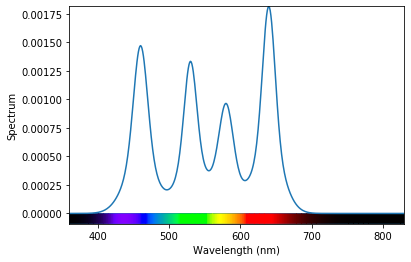

In [24]:
target = np.array([[50,1/3, 1/3]])
obj_fcn = [lx.cri.spd_to_iesrf, lx.cri.spd_to_iesrg]
obj_tar_vals = [90,110]
S, M = spb.spd_optimizer(target = target, \
                          tar_type = 'Yxy',\
                          cspace_bwtf = cspace_bwtf,\
                          component_spds = primaries,\
                          optimizer_type = '2mixer',\
                          obj_fcn = obj_fcn, \
                          obj_tar_vals = obj_tar_vals,\
                          verbosity = 0)

# Check output agrees with target:
xyz = lx.spd_to_xyz(S, relative = False, cieobs = cieobs)
Yxy = lx.xyz_to_Yxy(xyz)
cct,duv = lx.xyz_to_cct(xyz, cieobs = cieobs, mode = 'search',out = 'cct,duv')
Rf, Rg = [fcn(S)[0,0] for fcn in obj_fcn]
print('\nResults (optim,target):')
print("Yxy: ([{:1.0f},{:1.2f},{:1.2f}],[{:1.0f},{:1.2f},{:1.2f}])".format(Yxy[0,0],Yxy[0,1],Yxy[0,2],target[0,0],target[0,1],target[0,2]))
print("Rf: ({:1.2f},{:1.2f})".format(Rf, obj_tar_vals[0]))
print("Rg: ({:1.2f}, {:1.2f})".format(Rg, obj_tar_vals[1]))
print("cct(K), duv: ({:1.1f},{:1.4f})".format(cct[0,0], duv[0,0]))

print('\nFlux ratios of component spectra:', M)

#plot spd:
plt.figure()
lx.SPD(S).plot()

### 3.  spd_optimer2(): a flexible multi-objective spectral optimizer using local and global minimizers

**`spd_optimizer2()`** has predefined implementations for multi-objective **global optimization** using particle swarms (`'particleswarm'`) and differential evolutionary multi-objective optimization (`'demo'`), as well as local Nelder-Mead simplex optimization (`'nelder-mead'`). Note that the latter is also implemented in `spd_optimizer()`. It also allows for the user to plugin his own minimization algorithm to perform the spectral optmizer. As before, functions can be created that output multiple objective values to speed up calculation time. 

### 3.1 spd_optimer2(): *"free"* peak wavelengths and fwhm + *"predefined minimizer"*:
The example below performs an optimization with target chromaticity equal to (1/3, 1/3) using the predefined `'particleswarm'` minimization_method for a spectrum built-up from 4 primaries with a gaussian profile and with 2 objectives (Rf = 90 and Rg = 110). The wavelength [400,700] and fwhm [5,300] upper- and lower-bounds are specified in the `prim_constructor_parameter_defs` dictionary. 

In [25]:
# Set CIE CMF set, number of primaries n and target chromaticity:
cieobs = '1964_10'
n = 4
target = np.array([[200,1/3,1/3]]) 

# define function that calculates several objectives at the same time (for speed):
def spd_to_cris(spd):
    Rf,Rg = lx.cri.spd_to_cri(spd, cri_type='ies-tm30',out='Rf,Rg')
    return np.vstack((Rf, Rg))  

obj_fcn = [(spd_to_cris,'Rf','Rg')]
obj_tar_vals = [(90,110)]

2020-07-16 10:47:17,698 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|1000/1000, best_cost=0.00326
2020-07-16 10:49:46,540 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0032615688984472717, best pos: [3.9314e-01 6.6347e-01 6.3370e-02 3.7889e-01 6.2526e+02 5.3110e+02
 5.2220e+02 4.4827e+02 8.4680e+01 5.7220e+01 3.4279e+01 7.2653e+01]



Results (optim,target):
Yxy: ([200,0.33,0.33],[200,0.33,0.33])
Rf: (89.85,90.00)
Rg: (109.69, 110.00)
cct(K), duv: (5482.0,-0.0041)

Flux ratios of component spectra: [3.2459e-03 2.7855e-03 4.0941e-04 2.9389e-03]


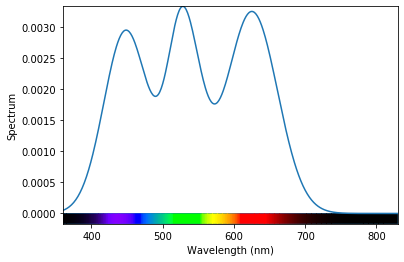

In [20]:
# start optimization:
S, prims, M = spb.spd_optimizer2(target, tar_type = 'Yxy', cspace_bwtf = {},
                                  n = n, wlr = [360,830,1], prims = None,
                                  cieobs = cieobs, out = 'spds,primss,Ms', 
                                  prim_constructor = spb.gaussian_prim_constructor,
                                  prim_constructor_parameter_types = ['peakwl', 'fwhm'], 
                                  prim_constructor_parameter_defs = {'peakwl_bnds':[400,700],
                                                                     'fwhm_bnds':[5,300]},
                                  obj_fcn = obj_fcn, obj_fcn_pars = [{}], 
                                  obj_fcn_weights = [(1,1)], obj_tar_vals = obj_tar_vals,
                                  triangle_strengths_bnds = None,
                                  minimize_method = 'particleswarm',
                                  minimize_opts = {},
                                  verbosity = 0)

# Check output agrees with target:
xyz = lx.spd_to_xyz(S, relative = False, cieobs = cieobs)
Yxy = lx.xyz_to_Yxy(xyz)
cct,duv = lx.xyz_to_cct(xyz, cieobs = cieobs, mode = 'search',out = 'cct,duv')
Rf, Rg = obj_fcn[0][0](S)
print('\nResults (optim,target):')
print("Yxy: ([{:1.0f},{:1.2f},{:1.2f}],[{:1.0f},{:1.2f},{:1.2f}])".format(Yxy[0,0],Yxy[0,1],Yxy[0,2],target[0,0],target[0,1],target[0,2]))
print("Rf: ({:1.2f},{:1.2f})".format(Rf[0], obj_tar_vals[0][0]))
print("Rg: ({:1.2f}, {:1.2f})".format(Rg[0], obj_tar_vals[0][1]))
print("cct(K), duv: ({:1.1f},{:1.4f})".format(cct[0,0], duv[0,0]))

print('\nFlux ratios of component spectra:', M)

#plot spd:
plt.figure()
lx.SPD(S).plot()

### 3.2 spd_optimer2():  *"free"* peak wls & *"fixed"* fwhm + *"user-defined minimizer and primary constructor"*:
To show the flexibility of **`spd_optimizer2()`**, in the next example, a user-defined *minimization algorithm* is defined and a user-defined *`prim_constructor`* function with a 2nd order Lorentzian profile (instead of the default Gaussian one) is set up. The **`user_prim_constructor()`** uses the toolbox's internal function **`_setup_wlr()`** and **`_extract_prim_optimization_parameters()`** to create the correct wavelength format and to extract the constructor parameters from the optimization parameter vector `x` and the function default set of parameters stored in `prim_constructor_parameter_defs`. The function should have the following interface:

    prims = prim_constructor(x, nprims, wlr, prim_constructor_parameter_types = ['peakwl','fwhm'],  **prim_constructor_parameter_defs)

The **fwhm of all primaries** is kept **fixed at 15 nm** by specifying these default values in that dictionary in addition to the upper- and lower-bounds. Note that should one create a function with different names for the constructor variables then the variable names for the bounds should match, e.g. `'spectral_width'` as constructor variable should have as name for its bounds: `'spectral_width_bnds'`. The exact names of the constructor variables should be specified in the `prim_constructor_parameter_types` list. 

The **`user_minim()`** function the following input arguments in that particular order and output a dictionary with optimization results that minimally contains a key **`'x_final'`** with the final values of the optimization vector `x`: 

    results = user_minim(fitnessfcn, Nparameters, args, bounds, verbosity = 1,**minimize_opts). 
    
Note that `minimize_opts` has been set to `{'pareto':False}`, as for the particleswarm minimizer the final output value of the fitness function is a single value obtained as the Root-Sum-Squares of the weighted fitness values of each objective function (and this for each particle, resulting in an (N x 1) ndarray). For true multi-objective minimizers this should be set to `True`, so that the output of the fitness function is an (N x k) ndarray (i.e. N individuals x k parameters) that can then evolve into the pareto optimal boundary.

2020-05-02 18:02:17,412 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████|1000/1000, best_cost=0.000136
2020-05-02 18:03:23,607 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.00013563955044203197, best pos: [6.2473e-01 3.1950e-01 7.1713e-01 2.4234e-01 6.2227e+02 5.2365e+02
 4.5203e+02 5.4681e+02 5.4917e+01 2.6140e+01 6.0023e+01 5.6056e+01]



Results (optim,target):
Yxy: ([200,0.33,0.33],[200,0.33,0.33])
Rf: (89.99,90.00)
Rg: (109.99, 110.00)
cct(K), duv: (5482.0,-0.0041)

Flux ratios of component spectra: [3.6181e-03 2.5393e-03 3.1697e-03 1.7154e-03]


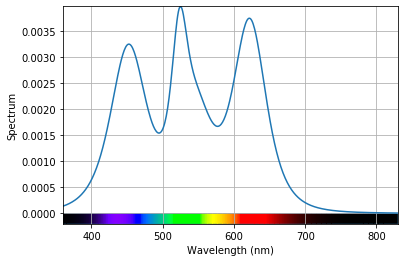

In [70]:
def user_prim_constructor2(x, nprims, wlr, 
                          prim_constructor_parameter_types = ['peakwl','spectral_width'], 
                          **prim_constructor_parameter_defs):
    """
    User defined prim constructor: lorenztian 2e order profile.
    """
    # Extract the primary parameters from x and prim_constructor_parameter_defs:
    pars = spb._extract_prim_optimization_parameters(x, nprims, prim_constructor_parameter_types,
                                                 prim_constructor_parameter_defs)
    # setup wavelengths:
    wlr = spb._setup_wlr(wlr)

    # Collect parameters from pars dict:
    n = 2*(2**0.5-1)**0.5
    spd = ((1 + (n*(pars['peakwl']-wlr.T)/pars['spectral_width'])**2)**(-2)).T
    return np.vstack((wlr, spd))


# Create a minimization function with the specified interface:
def user_minim2(fitnessfcn, Nparameters, args, bounds, verbosity = 1,
               **minimize_opts):
    results = lx.math.particleswarm.particleswarm(fitnessfcn, Nparameters, args = args, 
                                                 bounds = bounds, 
                                                 iters = 100, n_particles = 10, ftol = -np.inf,
                                                 options = {'c1': 0.5, 'c2': 0.3, 'w':0.9},
                                                 verbosity = verbosity)
    # Note that there is already a key 'x_final' in results
    return results


# start optimization:
S, prims, M = spb.spd_optimizer2(target, tar_type = 'Yxy', cspace_bwtf = {},
                              n = n, wlr = [360,830,1], prims = None,
                              cieobs = cieobs, out = 'spds,primss,Ms', 
                              prim_constructor = user_prim_constructor2,
                              prim_constructor_parameter_types = ['peakwl', 'spectral_width'], 
                              prim_constructor_parameter_defs = {'fwhm': [15],
                                                                 'peakwl_bnds':[400,700],
                                                                 'spectral_width_bnds':[5,300]},
                              obj_fcn = obj_fcn, obj_fcn_pars = [{}], 
                              obj_fcn_weights = [(1,1)], obj_tar_vals = obj_tar_vals,
                              triangle_strengths_bnds = None,
                              minimize_method = user_minim2,
                              minimize_opts = {'pareto':False},
                              verbosity = 0)


# Check output agrees with target:
xyz = lx.spd_to_xyz(S, relative = False, cieobs = cieobs)
Yxy = lx.xyz_to_Yxy(xyz)
cct,duv = lx.xyz_to_cct(xyz, cieobs = cieobs, mode = 'search',out = 'cct,duv')
Rf, Rg = obj_fcn[0][0](S)
print('\nResults (optim,target):')
print("Yxy: ([{:1.0f},{:1.2f},{:1.2f}],[{:1.0f},{:1.2f},{:1.2f}])".format(Yxy[0,0],Yxy[0,1],Yxy[0,2],target[0,0],target[0,1],target[0,2]))
print("Rf: ({:1.2f},{:1.2f})".format(Rf[0], obj_tar_vals[0][0]))
print("Rg: ({:1.2f}, {:1.2f})".format(Rg[0], obj_tar_vals[0][1]))
print("cct(K), duv: ({:1.1f},{:1.4f})".format(cct[0,0], duv[0,0]))

print('\nFlux ratios of component spectra:', M)

#plot spd:
plt.figure()
lx.SPD(S).plot()

### *NEW* 4. SpectralOptimizer: class based version of spd_optimizer2

The class based optimizer is based on four classes:
  1. **`PrimConstructor`**: instances have a function attribute `f` which should hold the handle to some primary constructor function with the following interface:
  
          prims = prim_constructor(x, nprims, wlr, ptypes = ['peakwl','fwhm'], **pdefs)
 
 The `ptypes` argument is a list with the names of all function variables that can be parameters for optimization (e.g. ['peakwl', fwhm']). The `pdefs` attribute is a dictionary with additional parameters for the primary construction or with list of values for the parameters (from 'ptypes') that should be kept fixed at those values during optimization. The `ptypes` and `pdefs` should be passed to class instance upon initialization.   
  
  2. **`ObjFcsn`**: instances of this class store everything to do with the objectives. Attribute `f` is a **list** of objective functions, `ft` is a list with target values, `fw` a list with relative weights and `decimals` as list with how the functions values should be rounded. As before, functions can be created that output multiple objective values to speed up calculation time and they should be entered as a tuple with the first element the function, and the others *names* for the output values. Initialize as: 
  
          obj_fcn = ObjFcns(f = [...,], ft = [...,], fw = [...,], decimals = [5])
      
  3. **`Minimizer`**: takes care of the minimization of the objective functions during spectral optimization (three methods have been built in: `'nelder-mead'` for local simplex minimization, `'particleswarm'` for (pseudo-)global minimization and `'demo'` (Differential Evolutionary Multi-objective Optimization). The former two try to minimize a pseudo-multi-objective problem by weighting the function values of all multi-objective functions set up in ObjFcns and then taking the Root-Sum-of-Squares of those values to minimize. The `'demo'` minimizer takes a pareto boundary approach and will output pareto optimal solutions. User-defined functions can also be setup. They should have the following interface:
    
            results = user_minim(fitnessfcn, npars, args_dict, bounds, verbosity = 1, **opts)
            
   results is a dictionary with minimization results where the final best solution(s) are stored at key: `'x_final'` !!
        
  4. **`SpectralOptimizer`**: does the actual spectral optimization. 
  
     a. First, an object of class SpectralOptimizer should be created: 
     
             so = SpectralOptimizer(...)
             
     b. Then, the `start()` function should be called with in keyword argument out the requested output, e.g. `'spds,Ms'`:
             
             spds, Ms = so.start(out = 'spds,Ms')
             

**Remark:** 
 * Several code optimizations have been made to increase the speed compared to `spd_optimizer2()`. For example, for the same problem (nprim = 4, [Rf, Rg] objectives, illuminant E target and the particleswarm minimizer, the class based optimizer is about 4 times faster!!!)

### 4.1 SpectralOptimizer:  *"free"* peak wavelengths and fwhm + *"predefined minimizer"*:
The example below performs an optimization with target chromaticity equal to (1/3, 1/3) using the predefined `'particleswarm'` minimization_method for a spectrum built-up from 4 primaries with a gaussian profile and with 2 objectives (Rf = 90 and Rg = 110). The wavelength [400,700] and fwhm [5,300] upper- and lower-bounds are specified in the *`pdefs`* dictionary in the `PrimaryConstructor` object.   
Note how the `ObjFcns` and `Minimizer` functions are also initialized during the `SpectralOptimizer` initialization.

In [9]:
# Set CIE CMF set, number of primaries n and target chromaticity:
cieobs = '1964_10'
nprim = 4
target = np.array([[200,1/3,1/3]]) 

# define function that calculates several objectives at the same time (for speed):
def spd_to_cris(spd):
    Rf,Rg = lx.cri.spd_to_cri(spd, cri_type='ies-tm30',out='Rf,Rg')
    return np.vstack((Rf, Rg))  

obj_fcn = [(spd_to_cris,'Rf','Rg')]
obj_tar_vals = [(90,110)]


Results (optim,target):
Yxy: ([200,0.33,0.33],[200,0.33,0.33])
Rf: (90.00,90.00)
Rg: (110.00, 110.00)
cct(K), duv: (5482.0,-0.0041)

Flux ratios of component spectra: [1.9795e-03 1.2460e-03 1.0676e-02 4.3945e-03]


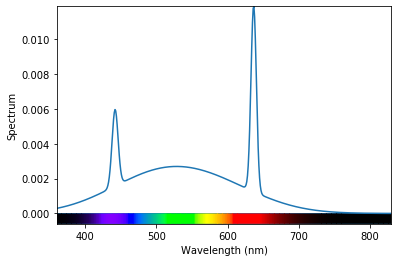

In [58]:
# start optimization:
so1 = spb.SpectralOptimizer(target = target, tar_type = 'Yxy', cspace_bwtf = {},
                            nprim = nprim, wlr = [360,830,1], cieobs = cieobs, 
                            optimizer_type = '3mixer',
                            prim_constructor = spb.PrimConstructor(pdefs = {'peakwl_bnds':[400,700],
                                                                            'fwhm_bnds':[5,300]}), 
                            obj_fcn = spb.ObjFcns(f=obj_fcn, ft = obj_tar_vals),
                            minimizer = spb.Minimizer(method='nelder-mead'),
                            verbosity = 0)

# start optimization and request optimized spectra spds and primary fluxes M as output:
S,M = so1.start(out = 'spds,Ms')

# Check output agrees with target:
xyz = lx.spd_to_xyz(S, relative = False, cieobs = cieobs)
Yxy = lx.xyz_to_Yxy(xyz)
cct,duv = lx.xyz_to_cct(xyz, cieobs = cieobs, mode = 'search',out = 'cct,duv')
Rf, Rg = spd_to_cris(S)
print('\nResults (optim,target):')
print("Yxy: ([{:1.0f},{:1.2f},{:1.2f}],[{:1.0f},{:1.2f},{:1.2f}])".format(Yxy[0,0],Yxy[0,1],Yxy[0,2],target[0,0],target[0,1],target[0,2]))
print("Rf: ({:1.2f},{:1.2f})".format(Rf[0], obj_tar_vals[0][0]))
print("Rg: ({:1.2f}, {:1.2f})".format(Rg[0], obj_tar_vals[0][1]))
print("cct(K), duv: ({:1.1f},{:1.4f})".format(cct[0,0], duv[0,0]))

print('\nFlux ratios of component spectra:', M)

#plot spd:
plt.figure()
lx.SPD(S).plot()

### 4.2 SpectralOptimizer:  *"free"* peak wls and *"fixed"* fwhm + *"user-defined minimizer and primary constructor"*:
To show the flexibility of the **`SpectralOptimizer`** class, in the next example, a user-defined *minimization algorithm* is defined and a user-defined *`prim_constructor`* function with a 2nd order Lorentzian profile (instead of the default Gaussian one) is set up. The **`user_prim_constructor()`** uses the toolbox's internal function **`_setup_wlr()`** and **`_extract_prim_optimization_parameters()`** to create the correct wavelength format and to extract the constructor parameters from the optimization parameter vector `x` and the function default set of parameters stored in `pdefs`. The constructor is initialized with the `PrimConstructor` class during the creation of the `SpectralOptimizer` instance. The function should have the following interface:

    prims = prim_constructor(x, nprims, wlr, ptypes = ['peakwl','fwhm'], **pdefs)

The **fwhm of all primaries** is kept **fixed at 15 nm** by specifying these default values in that dictionary in addition to the upper- and lower-bounds. Note that should one create a function with different names for the constructor variables then the variable names for the bounds should match, e.g. `'spectral_width'` as constructor variable should have as name for its bounds: `'spectral_width_bnds'`. The exact names of the constructor variables should be specified in the `ptypes` list and pas to the `PrimConstructor` class. 

The **`user_minim()`** function the following input arguments in that particular order and output a dictionary with optimization results that minimally contains a key **`'x_final'`** with the final values of the optimization vector `x`: 

    results = user_minim(fitnessfcn, npars, args, bounds, verbosity = 1,**opts). 
    
Note that `opts` has been set to `{'pareto':False}`, as for the particleswarm minimizer the final output value of the fitness function is a single value obtained as the Root-Sum-Squares of the weighted fitness values of each objective function (and this for each particle, resulting in an (N x 1) ndarray). For true multi-objective minimizers this should be set to `True`, so that the output of the fitness function is an (N x k) ndarray (i.e. N individuals x k parameters) that can then evolve into the pareto optimal boundary.

2020-07-11 01:12:38,980 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|▏                                                           |4/1000, best_cost=0.0233

User-Defined minimizer: user should (have) set the optimization options when defining minimizer!


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████|1000/1000, best_cost=0.000282
2020-07-11 01:13:31,903 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.00028249473929035744, best pos: [6.5813e-01 2.0132e-01 5.3547e-01 6.2244e-01 6.2416e+02 4.6405e+02
 4.4633e+02 5.3602e+02 3.9715e+01 6.2822e+01 4.7941e+01 6.6482e+01]



Results (optim,target):
Yxy: ([200,0.33,0.33],[200,0.33,0.33])
Rf: (90.02,90.00)
Rg: (110.02, 110.00)
cct(K), duv: (5482.0,-0.0041)

Flux ratios of component spectra: [4.2093e-03 8.7720e-04 2.3273e-03 3.0990e-03]


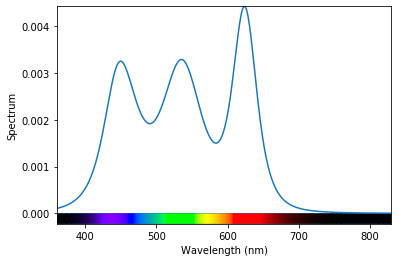

In [59]:
def user_prim_constructor(x, nprims, wlr, ptypes = ['peakwl','spectral_width'],**pdefs):
    """
    User defined prim constructor: lorenztian 2e order profile.
    """
    # Extract the primary parameters from x and prim_constructor_parameter_defs:
    pars = spb._extract_prim_optimization_parameters(x, nprims, ptypes, pdefs)
    # setup wavelengths:
    wlr = spb._setup_wlr(wlr)

    # Collect parameters from pars dict:
    n = 2*(2**0.5-1)**0.5
    spd = ((1 + (n*(pars['peakwl']-wlr.T)/pars['spectral_width'])**2)**(-2)).T
    return np.vstack((wlr, spd))


# Create a minimization function with the specified interface:
def user_minim(fitnessfcn, npars, args, bounds, verbosity = 1,**opts):
    results = lx.math.particleswarm.particleswarm(fitnessfcn, npars, args = args, 
                                                 bounds = bounds, 
                                                 iters = 100, n_particles = 10, ftol = -np.inf,
                                                 options = {'c1': 0.5, 'c2': 0.3, 'w':0.9},
                                                 verbosity = verbosity)
    # Note that there is already a key 'x_final' in results
    return results



so2 = spb.SpectralOptimizer(target = target, tar_type = 'Yxy', cspace_bwtf = {},
                        nprim = nprim, wlr = [360,830,1], cieobs = cieobs, 
                        out = 'spds,primss,Ms,results',
                        optimizer_type = '3mixer', triangle_strengths_bnds = None,
                        prim_constructor = spb.PrimConstructor(f = user_prim_constructor, 
                                                               ptypes=['peakwl','spectral_width'],
                                                               pdefs = {'fwhm' : [15],
                                                                        'peakwl_bnds':[400,700],
                                                                        'spectral_width_bnds':[5,300]}) , 
                        obj_fcn = spb.ObjFcns(f=obj_fcn, ft = obj_tar_vals),
                        minimizer = spb.Minimizer(method=user_minim),
                        verbosity = 0)

# start optimization:
S,M = so2.start(out = 'spds,Ms')

# Check output agrees with target:
xyz = lx.spd_to_xyz(S, relative = False, cieobs = cieobs)
Yxy = lx.xyz_to_Yxy(xyz)
cct,duv = lx.xyz_to_cct(xyz, cieobs = cieobs, mode = 'search',out = 'cct,duv')
Rf, Rg = spd_to_cris(S)
print('\nResults (optim,target):')
print("Yxy: ([{:1.0f},{:1.2f},{:1.2f}],[{:1.0f},{:1.2f},{:1.2f}])".format(Yxy[0,0],Yxy[0,1],Yxy[0,2],target[0,0],target[0,1],target[0,2]))
print("Rf: ({:1.2f},{:1.2f})".format(Rf[0], obj_tar_vals[0][0]))
print("Rg: ({:1.2f}, {:1.2f})".format(Rg[0], obj_tar_vals[0][1]))
print("cct(K), duv: ({:1.1f},{:1.4f})".format(cct[0,0], duv[0,0]))

print('\nFlux ratios of component spectra:', M)

#plot spd:
plt.figure()
lx.SPD(S).plot()

### 4.3 SpectralOptimizer:  *"predefined primary spectra"*
Spectral optimization can also be performed directly on a set of predefined primaries obtained through e.g. measurement or simulation.
The **`PrimConstructor` class** can be used to easily simulate some primary spectra. 
#### 4.3.1 PrimConstructor.get_spd(): *"predefined"* peak wavelengths and fwhm
For example to create an ndarray with 4 primaries with 4 predefined peak-wavelengths and fwhms:

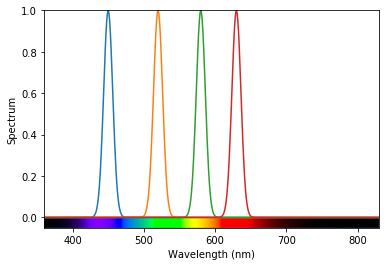

In [3]:
# create set of 4 primaries with fixed fwhm at 15 nm:
prims = spb.PrimConstructor(pdefs={'peakwl':[450,520,580,630],'fwhm':[15]}).get_spd()

lx.SPD(prims).plot()

#### 4.3.2 PrimConstructor.get_spd(): *"predefined"* peak wavelengths and *"random"* fwhm
For example to create an ndarray with 4 primaries with 4 predefined peak-wavelengths and random fwhms (with bounds [5,100]):

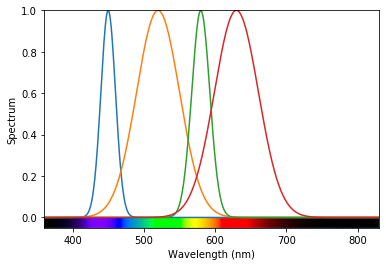

In [6]:
# create set of 4 primaries with fixed peakwl and fwhm bounds set to [5,100]:
prims2 = spb.PrimConstructor(pdefs={'peakwl':[450,520,580,630],
                                'fwhm_bnds':[5,100]}).get_spd()
lx.SPD(prims2).plot()

#### 4.3.3 PrimConstructor.get_spd(): *"random"* peak wavelengths and *"random"* fwhm
For example to create an ndarray with 4 primaries with random peak-wavelengths (with bounds [400,700]) and random fwhms (with bounds [5,100]):

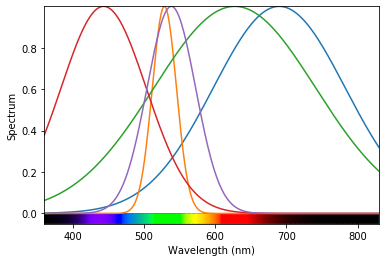

In [7]:
# create set of 5 primaries with free peakwl and free fwhm bounds set to [400,700] and [5,100]:
prims3 = spb.PrimConstructor(pdefs={'peakwl_bnds':[400,700],
                                'fwhm_bnds':[5,300]}).get_spd(nprim=5)
lx.SPD(prims3).plot()

#### 4.3.4 SpectralOptimizer: run with *"predefined primaries"*
The `SpectralOptimizer` can be run using one of the predefined set of primaries, e.g. *`prims2`*, by entering the ndarray in the `prims` keyword argument and setting the `prim_constructor` argument to `None`:


Results (optim,target):
Yxy: ([200,0.33,0.33],[200,0.33,0.33])
Rf: (89.85,90.00)
Rg: (109.70, 110.00)
cct(K), duv: (5482.0,-0.0041)

Flux ratios of component spectra: [4.9526e-03 3.2580e-03 8.9711e-04 3.3225e-03]


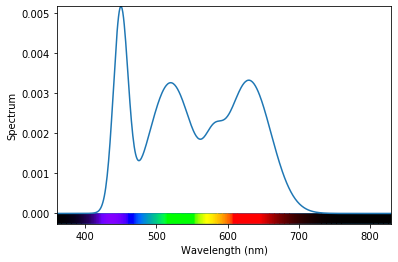

In [10]:
# Initialize SpectralOptimizer object:
so3 = spb.SpectralOptimizer(target = target, tar_type = 'Yxy', cspace_bwtf = {},
                      wlr = [360,830,1], cieobs = cieobs, 
                      out = 'spds,primss,Ms,results',
                      optimizer_type = '3mixer', triangle_strengths_bnds = None,
                      prim_constructor = None, 
                      prims = prims2,
                      obj_fcn = spb.ObjFcns(f=obj_fcn, ft = obj_tar_vals),
                      minimizer = spb.Minimizer(method='nelder-mead'),
                      verbosity = 0)

# start optimization:
S,M = so3.start(out = 'spds,Ms')

# Check output agrees with target:
xyz = lx.spd_to_xyz(S, relative = False, cieobs = cieobs)
Yxy = lx.xyz_to_Yxy(xyz)
cct,duv = lx.xyz_to_cct(xyz, cieobs = cieobs, mode = 'search',out = 'cct,duv')
Rf, Rg = spd_to_cris(S)
print('\nResults (optim,target):')
print("Yxy: ([{:1.0f},{:1.2f},{:1.2f}],[{:1.0f},{:1.2f},{:1.2f}])".format(Yxy[0,0],Yxy[0,1],Yxy[0,2],target[0,0],target[0,1],target[0,2]))
print("Rf: ({:1.2f},{:1.2f})".format(Rf[0], obj_tar_vals[0][0]))
print("Rg: ({:1.2f}, {:1.2f})".format(Rg[0], obj_tar_vals[0][1]))
print("cct(K), duv: ({:1.1f},{:1.4f})".format(cct[0,0], duv[0,0]))

print('\nFlux ratios of component spectra:', M)

#plot spd:
plt.figure()
lx.SPD(S).plot()

## Simulation and rendering of hyper-spectral images (.hypspcim)

Luxpy contains a module that can simulate a hyper-spectral image of any regular sRGB image by mapping the color coordinates of each pixel in the image to a sample from a spectral reflectance set that is near-metameric under CIE D65 or some other user specified reference spectrum. The algorithm uses SciPy’s `cKDTree` to find the closest neighbours to each pixel’s color coordinates and then calculates a weighted mean of the nearest spectral reflectance functions in a set. The user can provide a set, or else the IESTM30 4880 Reference set is used as default. The `render_image()` function can then simulate the effect of a light source on the color appearance of the imaged scene to explore the source’s color rendition properties. Note though that no account is taken (yet) for out-of-gamut values (i.e. no extrapolation has been implemented and out-of-gamut color coordinates are simply clipped). The following illustrates its use:

(681, 1024, 401)


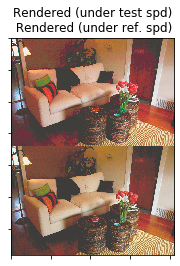

In [12]:
from luxpy import hypspcim
# Generate RGB LED spectrum:
S = spb.spd_builder(peakwl = [450,530,610],\
                    fwhm = [20,20,20],\
                    target = 4000,\
                    tar_type = 'cct') 

# Calculate hyper-spectral image
img = hypspcim._HYPSPCIM_DEFAULT_IMAGE #path to default image
img_hyp = hypspcim.render_image(img = img, 
                                cspace = 'xyz', \
                                interp_type = 'nd', \
                                spd = S, D = 1, \
                                show = True,\
                                stack_test_ref = 21) 
print(img_hyp.shape)

In the code above the stack_test_ref argument specifies how the rendered images under the test and reference light sources should be stacked (21: on top of one another or 12: next to each other).

## Display characterization (.dispcal)


This module allows for easy display characterization using Tone Response curves (to from display RGB to linear RGB) and 3x3 conversion matrices to transform linear RGB to XYZ or vice versa. The tone response curves are either a look-up-table (LUT) or a Gain-Offset-Gamma function. The module contains a `calibrate()`, `rgb_to_xyz()`, `xyz_to_rgb()` and `calibration_performance()` functions, as well as `DisplayCalibration` class for more ease of use of the functionality provided by the above functions. After importing the package, both the functional- and object-oriented-programming approaches are illustrated below using some RGB and XYZ values stored in two files in the data folder of this sub_package and loaded  (note that this data is also stored in `dispcal.\_RGB` and `dispcal.\_XYZ`):  

In [5]:
import luxpy.toolboxes.dispcal as dspc
import pandas as pd
rgbcal = pd.read_csv(dspc._PATH_DATA + 'RGBcal.csv', sep=',', header=None).values # read rgb data
xyzcal = pd.read_csv(dspc._PATH_DATA + 'XYZcal.csv', sep=',', header=None).values # read measured xyz data 

In both examples, the following settings will be used (see docstrings for other options):

In [6]:
cieobs = '1931_2' # CMF set corresponding to XYZ measurements
tr_type = 'lut' # or 'gog' ('gog': gain-offset-gamma approach, 'lut': look-up-table)
L_type = 'lms' # or 'Y' ('Y' : use RGB vs luminance for Tone-Response curve, 'lms', use R vs L, G vs M, B vs S)
avg = np.mean # function to average DEs in matrix optimization in calibrate()
cspace = 'lab' # colorspace in which color differences are calculated

### Functional programming approach
After measurement of the XYZ values corresponding to a set RGB display settings (see `calibrate()` for specific requirements of which type of RGB settings that need to be measured), the tone response LUT, conversion matrices and xyz of the black and white points can be obtained using the `calibrate()` function. 

M (lin. rgb to xyz): 
 [[1.0860e+02 4.6827e+01 3.6934e+01]
 [5.1140e+01 1.3336e+02 1.8603e+01]
 [1.6304e+00 1.5694e+01 2.0355e+02]]
N (xyz to lin. rgb): 
 [[1.0952e-02 -3.6513e-03 -1.6536e-03]
 [-4.2334e-03 8.9915e-03 -5.3628e-05]
 [2.3866e-04 -6.6398e-04 4.9301e-03]]
xyz_black: 
 [[4.4445e-01 4.5641e-01 7.6118e-01]]
xyz_white: 
 [[1.9318e+02 2.0394e+02 2.2202e+02]]


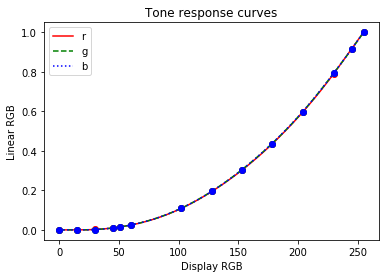

In [7]:
# Get calibration gog-parameters/lut and conversion matrices M, N as well as xyz-black:
M, N, tr, xyz_black, xyz_white = dspc.calibrate(rgbcal, xyzcal, L_type = L_type, tr_type = tr_type, avg = avg, cspace = cspace)
print('M (lin. rgb to xyz): \n', M)
print('N (xyz to lin. rgb): \n', N)
print('xyz_black: \n', xyz_black)
print('xyz_white: \n', xyz_white)

The performance of the calibration can be checked directly on the calibration data as follows:


Calibration performance (all colors): 
    DE(l*a*b*): avg = 0.20, std = 0.13
    DE(l*)    : avg = 0.10, std = 0.12
    DE(a*b*)  : avg = 0.15, std = 0.10


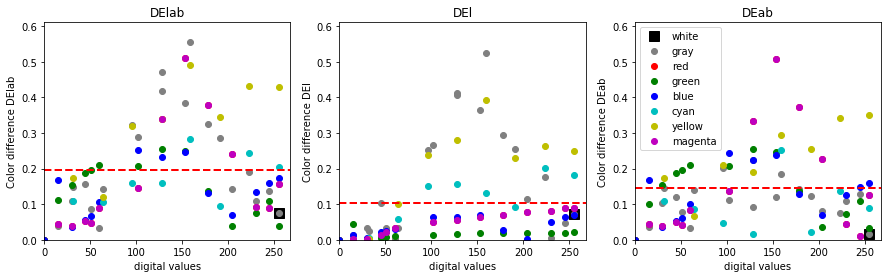

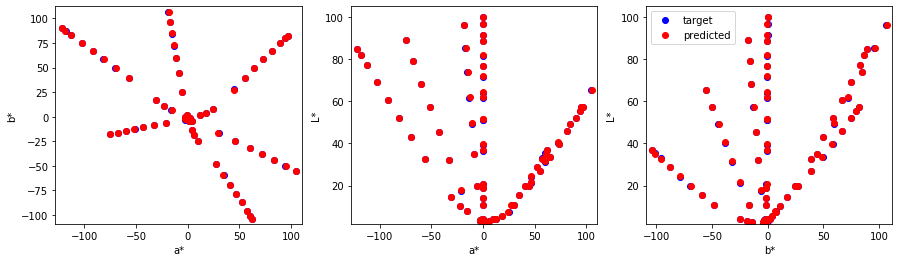

In [8]:
# Check calibration performance:
DElabi,DEli, DEabi = dspc.calibration_performance(rgbcal, xyzcal, M, N, tr, xyz_black, xyz_white, 
                                                cspace=cspace, tr_type = tr_type, avg = avg, 
                                                verbosity = 1, is_verification_data = False) 

Estimate the required RGB settings to obtain a specified XYZ value (also check inverse transform):

In [9]:
# define a test xyz for converion to rgb:
xyz_test = np.array([[100.0,100.0,100.0]])*0.5 
print('\nTest calibration for user defined xyz:\n    xyz_test_est:', xyz_test) # print chosen test xyz 

# for a test xyz calculate the estimated rgb:
rgb_test_est = dspc.xyz_to_rgb(xyz_test, N, tr, xyz_black, tr_type = tr_type) 
print('    rgb_test_est:', rgb_test_est) # print estimated rgb 

# calculate xyz again from estimated rgb (round-trip check: xyz->rgb->xyz):
xyz_test_est = dspc.rgb_to_xyz(rgb_test_est, M, tr, xyz_black, tr_type = tr_type)
print('    xyz_test_est:', np.round(xyz_test_est,1)) # print estimated xyz


Test calibration for user defined xyz:
    xyz_test_est: [[5.0000e+01 5.0000e+01 5.0000e+01]]
    rgb_test_est: [[148 137 134]]
    xyz_test_est: [[4.9800e+01 4.9800e+01 4.9600e+01]]


### Object-oriented programming approach: class DisplayCalibration

First, generate an object that contains all the required data for the conversions:

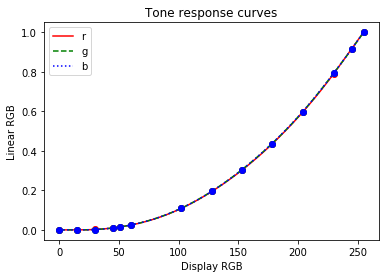

In [10]:
# Option 1: direct input of rgbcal and xyzcal data (verbosity = 0: don't print/plot results):
cal1 =  dspc.DisplayCalibration(rgbcal, xyzcal = xyzcal, L_type = L_type, cieobs = cieobs, 
                                tr_type = tr_type, avg = avg, cspace = cspace,
                                verbosity = 0)

# Option 2: input of rgbcal and xyzcal by filename (note that this also works for calibrate()!):
cal2 =  dspc.DisplayCalibration(dspc._PATH_DATA + 'RGBcal.csv', 
                                xyzcal = dspc._PATH_DATA + 'XYZcal.csv', 
                                L_type = L_type, cieobs = cieobs, 
                                tr_type = tr_type, avg = avg, cspace = cspace,
                                verbosity = 1, sep =',')

The performance of the calibration can be checked directly on the calibration data as follows:


Calibration performance (all colors): 
    DE(l*a*b*): avg = 0.20, std = 0.13
    DE(l*)    : avg = 0.10, std = 0.12
    DE(a*b*)  : avg = 0.15, std = 0.10

peformance (dict):  {'DElab_mean': 0.19614417817572136, 'DElab_std': 0.12622888237163915, 'DEli_mean': 0.10339577954343367, 'DEl_std': 0.11510560593907368, 'DEab_mean': 0.14606925507743548, 'DEab_std': 0.09555131789854956}


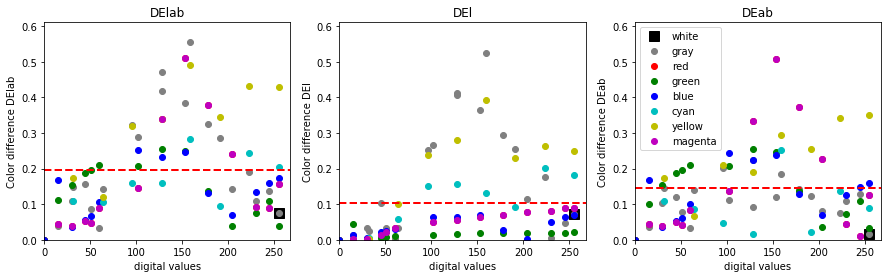

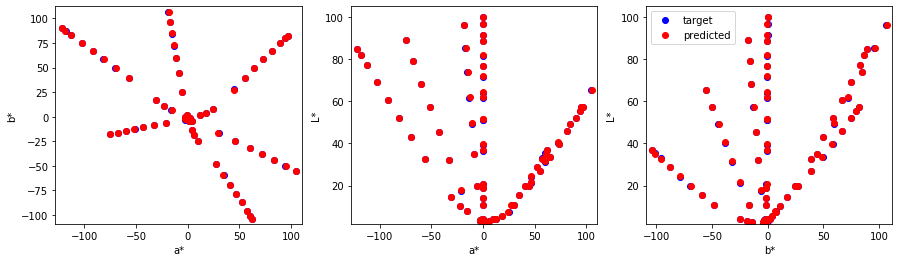

In [11]:
# Check calibration performance for calibration data itself:
performance = cal2.check_performance()
print('\npeformance (dict): ', performance)

Estimate the required RGB settings to obtain a specified XYZ value (also check inverse transform):

In [12]:
# define a test xyz for converion to rgb:
xyz_test = np.array([[100.0,100.0,100.0]])*0.5 
print('\nTest calibration for user defined xyz:\n    xyz_test_est:', xyz_test) # print chosen test xyz 

# for a test xyz calculate the estimated rgb:
rgb_test_est = cal1.to_rgb(xyz_test)
print('    rgb_test_est:', rgb_test_est) # print estimated rgb 

# calculate xyz again from estimated rgb (round-trip check: xyz->rgb->xyz):
xyz_test_est = cal1.to_xyz(rgb_test_est)
print('    xyz_test_est:', np.round(xyz_test_est,1)) # print estimated xyz


Test calibration for user defined xyz:
    xyz_test_est: [[5.0000e+01 5.0000e+01 5.0000e+01]]
    rgb_test_est: [[148 137 134]]
    xyz_test_est: [[4.9800e+01 4.9800e+01 4.9600e+01]]


The performance can also be verified with a different set of measured xyz and target xyz. To let the `performance()` function know that the `rgb` input argument actually contains measured xyz data, set `rgb_is_xyz = True`. To let the `performance()` function know that in this verification set, there are not necessarily pure RGB's, whites, grays, ... available, set `is_verification_data = True` (No plot of DE vs R,G,B will be made!).
##### (For this example some xyz data is 'predicted' to use as measured verification data, and the data in `xyzcal` is used as target data, but in practice one would enter actual measured XYZ data and the target XYZ data.)


Calibration performance (all colors): 
    DE(l*a*b*): avg = 0.20, std = 0.13
    DE(l*)    : avg = 0.10, std = 0.12
    DE(a*b*)  : avg = 0.15, std = 0.10


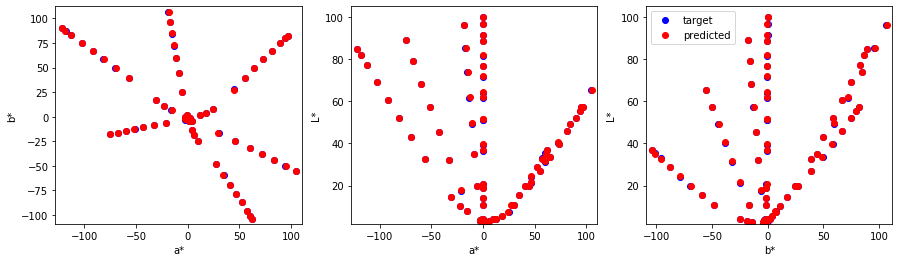

In [90]:
# Create some 'measured' and 'target' XYZ data:
xyz_verification = cal1.to_xyz(rgbcal)
xyz_target = xyzcal

# Do performance check:
performance = cal1.check_performance(xyz_verification, xyz_target, 
                                     rgb_is_xyz = True, is_verification_data = True,
                                     verbosity = 1)

## Spectral measurements (.spectro)

The LuxPy **`spectro`** toolbox supports spectral measurements with several **JETI** (e.g. specbos 1211) and **OceanOptics** (e.g. Redtide, USB2000, QE65Pro, QE65000, ...) spectrometers. 
### Installation
* **`jeti`** makes use of dll's supplied by JETI. The dll's are installed together with luxpy. One only need to install the drivers. If you're lucky, this is done automatically by Windows. 
* **`oceanoptics`** makes use of the **seabreeze** open source drivers, the **`python-seabreeze`** and the **`pyubs`** python packages. These need to be manually installed, before you can make use of the toolbox!

### import

In [ ]:
from luxpy.toolboxes import spectro as sp

### Initialization

To initialize the `jeti` sub-package:

In [9]:
sp.init('jeti') 

<module 'luxpy.toolboxes.spectro.jeti.jeti' from 'D:\\Documents\\GitHub\\luxpy\\luxpy\\toolboxes\\spectro\\jeti\\jeti.py'>

To initialize the `oceanoptics` sub-package:

In [8]:
sp.init('oceanoptics')

<module 'luxpy.toolboxes.spectro.oceanoptics.oceanoptics' from 'D:\\Documents\\GitHub\\luxpy\\luxpy\\toolboxes\\spectro\\oceanoptics\\oceanoptics.py'>

### Get a spectrum
One can use the *`get_spd()`* function in **`*spectro`** to perform a spectral measurement. This function is a wrapper around identically named functions in the **`jeti`** and **`oceanoptics`** sub-packages. They share a number of common input arguments, but some are different, so look at the `__doc__` string of each for help on the specific inputs. 

#### luxpy.spectro.jeti

For info on the input arguments of *`spectro.jeti.get_spd()`*, execute the cell below.

In [ ]:
?sp.jeti.get_spd

Use the *`spectro.jeti.get_spd()`* function directly to make a spectral measurement:

In [ ]:
spd = sp.jeti.get_spd() 

Use the *`spectro.get_spd()`* function to make a spectral measurement:

In [ ]:
spd = sp.get_spd(manufacturer = 'jeti') 

Find optimum integration time and measure:

In [ ]:
spd = sp.get_spd(manufacturer = 'jeti', Tint = 0)

Find optimum integration time (but smaller than 2 seconds) and measure:

In [ ]:
spd = sp.get_spd(manufacturer = 'jeti', Tint = 0, autoTint_max = 2)

Measure exactly one second:

In [ ]:
spd = sp.get_spd(manufacturer = 'jeti', Tint = 1)

Turn pilot laser ON (to see what is being measured); this can also be set directly during a measurement by the input argument `laser_on` of *`get_spd()`* while also setting the `Tint` argument to `None`:

In [ ]:
Errors = sp.jeti.set_laser(laser_on=True)

Turn pilot laser OFF (if is was still ON when initiating a measurement, it will be turned OFF automatically):

In [ ]:
Errors = sp.jeti.set_laser(laser_on=False) 

#### luxpy.spectro.oceanoptics

For info on the input arguments *`spectro.oceanoptics.get_spd()`*, execute the cell below.

In [ ]:
?sp.oceanoptics.get_spd

Use the *`spectro.oceanoptics.get_spd()`* function directly to make a spectral measurement:

In [ ]:
spd = sp.oceanoptics.get_spd() 

Use the *`spectro.get_spd()`* function to make a spectral measurement:

In [ ]:
spd = sp.get_spd(manufacturer = 'oceanoptics') 

Find optimum integration time and measure

In [ ]:
spd = sp.get_spd(manufacturer = 'oceanoptics', Tint = 0) 

Find optimum integration time (but smaller than 2 seconds) and measure:

In [ ]:
spd = sp.get_spd(manufacturer = 'oceanoptics', Tint = 0, autoTint_max = 2) 

Measure exactly one second:

In [ ]:
spd = sp.get_spd(manufacturer = 'oceanoptics', Tint = 1) 

Get the temperature (°C) of the device:

In [ ]:
tempC, Errors = sp.oceanoptics.get_temperature()

Set the temperature (°C) of the device (default = -20); this can also be set directly during a measurement by the input argument `tempC` of *`get_spd()`*:

In [ ]:
Errors = sp.oceanoptics.set_temperature()